<a href="https://colab.research.google.com/github/kmayerb/i4TB_Jan_2022/blob/main/i4TB__tcrdist3_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# i4TB  tcrdist3 demonstration: tcrdist3 for flexible distance based TCR analysis in Python

Koshlan Mayer-Blackwell [1] and Andrew Fiore-Gartland [1]

1 Vaccine and Infectious Disease Division, Fred Hutchinson Cancer Research Center, Seattle, USA



# Overview 

## Common hurdles in TCR repertoire analysis

1. Identifying motifs in epitope-specific paired αβ TCR data
2. Quantifying similar non-identical receptores to a reference set in bulk repertoires
3. Identifying unexpected clones in a bulk repertoire.

## Skills you should learn from this demonstration

1. Understand how to import and manipulate data with tcrdist3
2. Compute pairwise or ‘rectangular-wise’ distance matrices
3. Convert matrices to TCR networks
4. Find similar non identical clones to a reference set
5. Compare a set of sequences to a relevant background of naïve receptors
6. Estimate unexpectedness of a clone based on it Pgen and its number of highly similar ‘neighboring’ receptors. 


## What is TCRdist and tcrdist3?


The complementarity determining regions (CDRs) of a TCR receptor determines its binding affinity with peptide-MHC (pMHC) complexes. Previously, Dash et al., (2017) introduced TCRdist, a weighted multi-CDR distance metric, which enabled grouping of paired αβ TCRs by antigen specificity based on their sequence similarity. 

Tcrdist3 is an interactive python package that can be used to compute TCRdists and for pairwise distance computation between single-chains or paired-chain TCRs. We anticipate users may find the tcrdist3 python package useful for examining TCR receptor sequence features conferring antigen specificity, as well as for use cases where a library of previously annotated TCRs is compared to an unannotated TCR repertoire, without relying on direct sequence matching. 


## This notebook 

In this notebook: 

1. We show how tcrdist3 can be used to examine shared sequence features of antigen-specific TCRs in a paired-chain SARS-CoV-2 epitope-specific dataset recently generated by Minervina and Pogorelyy et al. 2021. 

2. We consider how tcrdist3 can be applied to find potentially interesting clusters of similar TCRs within an unnannotated set of repertoires from COVID-19 patients.

3. We consider how tcrdist3 can be applied directly to bulk repertoires to identify clones most likely to be under antigenic selection. Appendices provide additional technical details.


 


# Installation

More guidance on installation is provided at the project's documentation page (https://tcrdist3.readthedocs.io/).


In [117]:
%%capture
#pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
!pip install tcrdist3==0.2.2

# 1. Epitope-Specific Paired αβ TCR Data

### Preprocessing the easy way with Python!

The data generated by Minervina and Pogorelyy et al., 2021 contains the following columns 'cdr3b', 'cdr3b_nt', 'vb', 'jb', 'cdr3a', 'cdr3a_nt', 'va', 'ja','clonotype_id', 'Degree', 'cl_120', 'cl_120_members', 'donor',' epitope', 'specificity', and 'category'. After loading the data into a Pandas DataFrame, we rename the critical columns to match column names expected by *tcrdist3.* 

* *Tcrdist3* only requires 3 input columns for single chain analysis (i.e., for beta chain `cdr3_b_aa` and `v_b_gene`, `j_b_gene`) and 6 columns for paired chain analysis (i.e., `cdr3_b_aa`, `v_b_gene`, `j_b_gene`, `cdr3_a_aa`, `v_a_gene`, and `j_a_gene`). More columns can be included depending on the application. 

In [118]:
# Check that file for example 1 available. If not, download it.
import os 
f = 'clonotypes_minervina.tsv'
if not os.path.isfile(f):
  os.system('wget https://raw.githubusercontent.com/kmayerb/tcrdist3_book_chapter/main/data/clonotypes_minervina.tsv')
# Make a folder 'data' where some outputs will be written
path = 'data'
if not os.path.isdir(path):
  os.mkdir(path)

In [178]:
import os 
import pandas as pd
import numpy as np
from tcrdist.repertoire import TCRrep

# Load Pandas DataFrame from SI Table 6 (Minervina and Pogorelyy et al., 2021)
f = 'clonotypes_minervina.tsv'
df = pd.read_csv(f,sep ="\t")

# Subset to top 6 epitopes.
list_of_epitopes = ['A01_TTD', 'A02_YLQ', 'A01_LTD', 
                    'B15_NQK', 'A01_FTS', 'A24_NYN']
df = df[ df['epitope'].isin(list_of_epitopes)].\
  reset_index(drop = True)

# Rename columns.
df = df.rename(columns = {
    'cdr3b':'cdr3_b_aa', 
    'vb'   :'v_b_gene', 
    'jb'   :'j_b_gene',
    'cdr3a':'cdr3_a_aa', 
    'va'   :'v_a_gene', 
    'ja'   :'j_a_gene',
    'donor':'subject'} )

# Preview the first 2 lines of DataFrame.
df.head(2)

,cdr3_b_aa,cdr3b_nt,v_b_gene,j_b_gene,cdr3_a_aa,cdr3a_nt,v_a_gene,j_a_gene,clonotype_id,Degree,cl_120,cl_120_members,subject,epitope,specificity,category
0,CASSLAGYEQYF,TGCGCCAGCAGCTTGGCGGGGTACGAGCAGTACTTC,TRBV5-1,TRBJ2-7,CAVDIRAGNMLTF,TGTGCCGTGGACATAAGAGCAGGCAACATGCTCACCTTT,TRAV39,TRAJ39,1,0,1,1,N2,A01_LTD,spike,vax
1,CASSLGFPNQPQHF,TGTGCCAGCAGTTTGGGTTTCCCCAATCAGCCCCAGCATTTT,TRBV27,TRBJ1-5,CGTELRGKLIF,TGCGGCACAGAGCTCCGGGGAAAGCTTATCTTC,TRAV30,TRAJ23,2,0,2,1,R9,A01_LTD,spike,after_2


Minervina and Pogorelyy et al., 2021 did not provide allele level resolution in the V and J gene calls (e.g., TRBV5-1 vs. TRBV5-1*01). Because tcrdist3 infers CDR1, CDR2, and CDR2.5 from the full gene and allele name, we must append an allele designation when it is unresolved in the input data. We will also assign a 'count' number of 1 to each clonotype in the table.

In [179]:
# Add *01 allele level designation.
df['v_a_gene']  = df['v_a_gene'].apply(lambda x: f"{x}*01")
df['v_b_gene']  = df['v_b_gene'].apply(lambda x: f"{x}*01")
df['j_a_gene']  = df['j_a_gene'].apply(lambda x: f"{x}*01")
df['j_b_gene']  = df['j_b_gene'].apply(lambda x: f"{x}*01")
df['count'] = 1
df.head()

,cdr3_b_aa,cdr3b_nt,v_b_gene,j_b_gene,cdr3_a_aa,cdr3a_nt,v_a_gene,j_a_gene,clonotype_id,Degree,cl_120,cl_120_members,subject,epitope,specificity,category,count
0,CASSLAGYEQYF,TGCGCCAGCAGCTTGGCGGGGTACGAGCAGTACTTC,TRBV5-1*01,TRBJ2-7*01,CAVDIRAGNMLTF,TGTGCCGTGGACATAAGAGCAGGCAACATGCTCACCTTT,TRAV39*01,TRAJ39*01,1,0,1,1,N2,A01_LTD,spike,vax,1
1,CASSLGFPNQPQHF,TGTGCCAGCAGTTTGGGTTTCCCCAATCAGCCCCAGCATTTT,TRBV27*01,TRBJ1-5*01,CGTELRGKLIF,TGCGGCACAGAGCTCCGGGGAAAGCTTATCTTC,TRAV30*01,TRAJ23*01,2,0,2,1,R9,A01_LTD,spike,after_2,1
2,CASSDDGTGIETQYF,TGTGCCAGCAGCGATGATGGGACAGGGATTGAGACCCAGTACTTC,TRBV9*01,TRBJ2-5*01,CAASAFISNTGKLIF,TGTGCAGCAAGCGCATTCATAAGCAACACAGGCAAACTAATCTTT,TRAV29/DV5*01,TRAJ37*01,3,0,3,1,R6,A01_TTD,non-spike,inf,1
3,CASSEGITSNQPQHF,TGTGCCAGCAGCGAAGGGATTACTAGCAATCAGCCCCAGCATTTT,TRBV7-2*01,TRBJ1-5*01,CAVRTSGTYKYIF,TGTGCTGTGAGAACCTCAGGAACCTACAAATACATCTTT,TRAV21*01,TRAJ40*01,5,5,4,7,R6,A01_LTD,spike,inf_vax,1
4,CASSNPGPWGSPLHF,TGTGCCAGCAGTAATCCGGGACCCTGGGGCTCACCCCTCCACTTT,TRBV6-5*01,TRBJ1-6*01,CAVPGNNDMRF,TGTGCCGTCCCGGGTAACAATGACATGCGCTTT,TRAV39*01,TRAJ43*01,10,0,6,1,N4,A01_LTD,spike,vax,1


### Importing the data via TCRrep 

Once the data is properly formatted, the next step is to connect the data to an instance of the `TCRrep` class. The header of almost all scripts working with tcrdist3 includes the import statement `from tcrdist.repertoire import TCRrep`. When a `TCRrep` instance is initialized, the user must specify some key information along with the input data:

* `organism` specifies the appropriate organism. Either the character string 'human' or 'mouse' must be specified. 
* `chains` specifies whether the  TCRrep instance will evaluate a single chain or paired chain data. Provide `['alpha']` or `['beta']` to the `chains` argument for single-chain analysis. For paired chain analysis, supply `['alpha', 'beta']`. Tcrist3 supports [gamma]` , `[delta]`, or `['gamma', 'delta']` as available options as well 

The `organism` and `chains` arguments ensure the correct lookup when appending CDR1, CDR2, and CDR2.5 sequences to the input `cell_df` DataFrame.  To append these germline-encoded CDR sequences, tcrdist3 must recognize the user-supplied V gene names. The package uses IMGT nomenclature and a library of allele-specific reference genes. 

### The `cell_df` vs. `clone_df`?

Before proceeding, it is also helpful to understand that each TCRrep instance contains two pandas DataFrames: (i) the cell_df, which is provided by the user at initialization, and (ii) the clone_df, which is generated by the program immediately thereafter. The cell_df contains the data specified by the user, which is then augmented with columns containing IMGT aligned CDR1, CDR2, and CDR2.5 inferred from the V-gene name. The `clone_df` is a derivative Pandas DataFrame generated by deduplicating identical rows in the `cell_df.` That is, the rows of the `cell_df` with identical values are grouped together and the count column is updated to reflect the aggregation of multiple rows.  Also, it is helpful to know that the order of the rows in the `clone_df` will not match the order in `cell_df`. (Although not recommended for new users of tcrdist3, users who pre-check their data to ensure no missing values and no unrecognized V-gene names, may use the option `deduplicate = False` which will allow the `cell_df` row order to be directly transferred to the `clone_df` without any row removal.)

* `cell_df` contains TCR data. At the risk of repeating ourselves, it cannot be stressed enough that only the relevant columns should be passed in the DataFrame to the `cell_df` argument. This is critical because a NaN (missing value) in any column will result in the corresponding row being removed from the analysis.  
* If the user wishes to retain clones identical at the amino acid level but with distinct CDR3 nucleotide junctions, the nucleotide sequence or another unique-valued column should be provided in the DataFrame passed to the `cell_df` argument. 
* Finally, remember that any row of `cell_df` with an unrecognized V gene name will be removed from the final `clone_df`. It is possible to see those lines of `cell_df` not integrated into `clone_df` by calling `tr.show_incomplete()` after initialization. 



## All vs. All Comparison

### Pairwise Distance Matrices

We now initialize a `TCRrep` instance with the following arguments:

In [180]:
from tcrdist.repertoire import TCRrep
tr = TCRrep(cell_df = df[['subject','epitope','cdr3_a_aa','v_a_gene',
                          'j_a_gene','cdr3_b_aa','v_b_gene','j_b_gene',
                          'category','count','cdr3a_nt','cdr3b_nt']], 
            organism = 'human', 
            chains = ['alpha','beta'],
            deduplicate = True,
            compute_distances = True)

For datasets containing fewer than 10,000 unique clones, the default initialization of a `TCRrep` instance automatically computes pairwise distances across all CDRs. This completes in 1-60 seconds depending on the size of the input. (Automatic computation of pairwise distances can be disabled by setting `compute_distances = False`.) 

After initiailization, with the default `compute_distances = True`, the user can immediately access the following pairwise distances as Numpy arrays:

* `tr.pw_cdr1_a_aa`
* `tr.pw_cdr2_a_aa`
* `tr.pw_pmhc_a_aa` (CDR2.5 - the pMHC-facing loop between CDR2 and CDR3, which are referred to in tcrdist3 as pmhc_a)
* `tr.pw_cdr3_b_aa`
* `tr.pw_cdr1_b_aa`
* `tr.pw_cdr2_b_aa`
* `tr.pw_pmhc_b_aa` (CDR2.5 - the pMHC-facing loop between CDR2 and CDR3, which are referred to in tcrdist3 as pmhc_b)
* `tr.pw_cdr3_a_aa`

And the weighted multi-CDR distance matrices:
* `tr.pw_alpha`
* `tr.pw_beta`

The curious reader can confirm the following to see how the individual CDR3 matrices are combined to arrive at weighted multi-CDR distance.

In [181]:
import numpy as np
np.all(tr.pw_beta == (tr.weights_b['cdr1_b_aa']*tr.pw_cdr1_b_aa + 
                      tr.weights_b['cdr2_b_aa']*tr.pw_cdr2_b_aa+ 
                      tr.weights_b['pmhc_b_aa']*tr.pw_pmhc_b_aa + 
                      tr.weights_b['cdr3_b_aa']*tr.pw_cdr3_b_aa))

True

Since `tr.pw_beta` and `tr.pw_alpha` have identical dimensions and a consistent row order (matching the row order of the `TCRrep.clone_df`), a paired tcrdist can be generated by simply adding the matrices together.

In [182]:
tr.pw_alpha_beta = tr.pw_beta + tr.pw_alpha

There are additional options that allow customization of the pairwise distance computation or use of alternative metrics such as Smith-Waterman alignment score, aligned Hamming distance, or edit distance. The project's [documentation page](https://tcrdist3.readthedocs.io/) discusses these options in more detail and Appendix B of this chapter illustrates how to compute pairwise CDR3 edit distance instead of TCRdist.


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


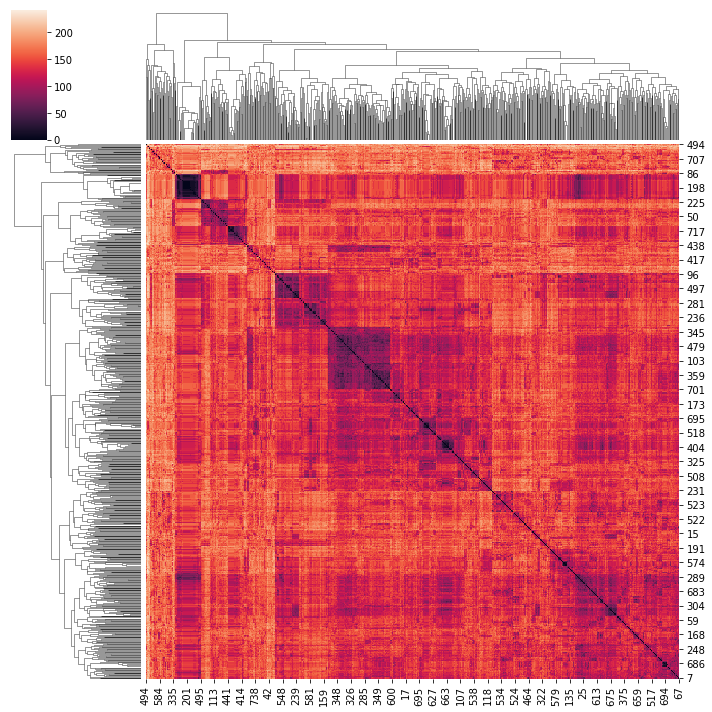

In [183]:
import seaborn as sns
sns.clustermap(data = tr.pw_beta)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


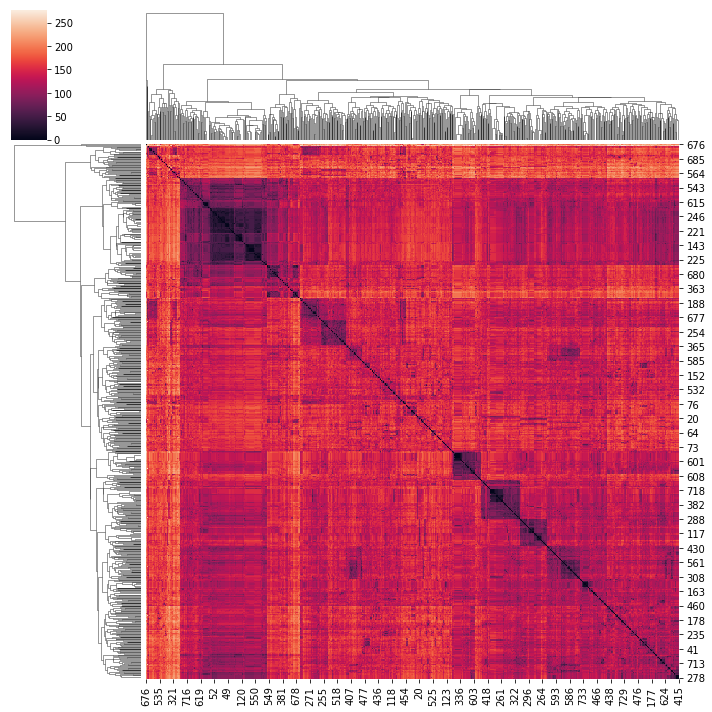

In [184]:
import seaborn as sns
sns.clustermap(data = tr.pw_alpha)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


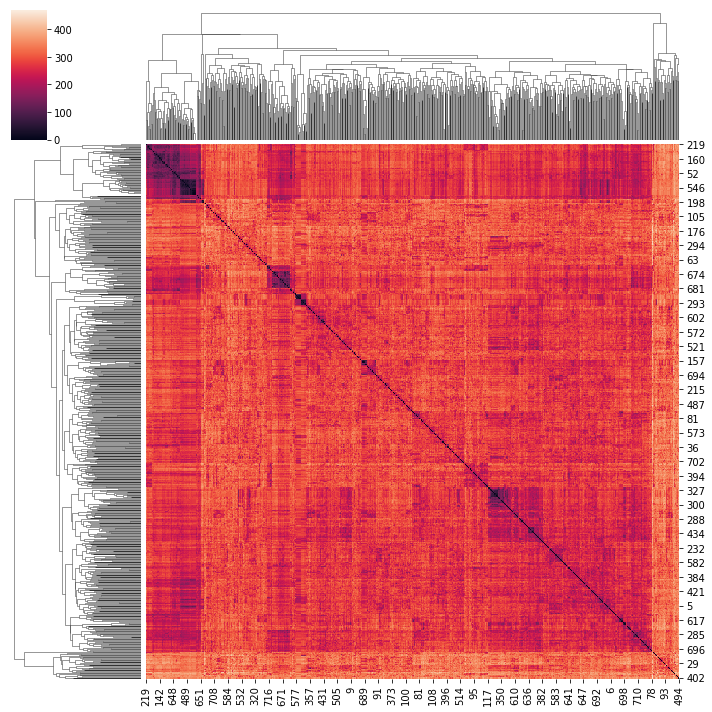

In [185]:
import seaborn as sns
sns.clustermap(data = tr.pw_alpha + tr.pw_beta)

### Distance Matrices to Networks

One can construct a weighted network with edges connecting similar TCRs from these pairwise distance matrices. The threshold at which to construct edges between clones is flexible, but for paired chain (default 3-fold CDR3-weighted) TCRdist, Minervina and Pogorelyy et al., (2021) selected a threshold of 120 TCRdistance units. We repeat that choice here. Note that any data in the `tr.clone_df` can also be used to describe a node in a TCR network. It is easy to lookup these values since the row index of `tr.clone_df` matches the row and column order of the pairwise distance matrices. This is illustrated in the code below.

In [186]:
from tcrdist.public import _neighbors_fixed_radius
# <edge_threshold> is used to define maximum distance to for a network edge.
edge_threshold = 120
# <tr.pw_alpha_beta> is paired chain TCRdist.
tr.pw_alpha_beta = tr.pw_beta + tr.pw_alpha
# <network> initialize a list to populate with edges between TCRs.
network = list()
for i,n in enumerate(_neighbors_fixed_radius(tr.pw_alpha_beta, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                (tr.pw_alpha_beta )[i,j],          # 'dist'- gets the distance between TCR(i,j)
                tr.clone_df['v_b_gene'].iloc[i],   # 'v_b_gene_1' - v beta gene of clone i
                tr.clone_df['v_b_gene'].iloc[j],   # 'v_b_gene_2' - v beta gene of clone j
                tr.clone_df['cdr3_b_aa'].iloc[i],  # 'cdr3_b_aa_1' - cdr3 beta of clone i
                tr.clone_df['cdr3_b_aa'].iloc[j],  # 'cdr3_b_aa_2' - cdr3 beta of clone j
                tr.clone_df['subject'].iloc[i],    # 'subject_1' - subject of clone i
                tr.clone_df['subject'].iloc[j],    # 'subject_2' - subject of clone j
                tr.clone_df['epitope'].iloc[i],    # 'epitope_1' - epitope associated with clone i
                tr.clone_df['epitope'].iloc[j],    # 'epitope_2' - epitope associated with clone j
                len(n)-1))                         # 'K_neighbors' - number of neighbors

cols = ['node_1', 'node_2', 'dist', 'v_b_gene_1', 'v_b_gene_2', 
        'cdr3_b_aa_1','cdr3_b_aa_2', 'subject_1','subject_2',
        'epitope_1','epitope_2', 'K_neighbors']
# Store the <network> edge list as a DataFrame.        
df_net = pd.DataFrame(network, columns = cols)
# Optinoally, write the edge list to a file for use in Gephi, Cytoscape, R, etc.
outfile = os.path.join(path,f"{f}_paired_TCRdist_{edge_threshold}_network.csv")
df_net.to_csv(outfile, sep = ",", index = False)

Once all of the network edges are repressented as unique rows in the `df_net` DataFrame, we can add columns to designate edges that unite nodes that come from different donors (i.e., those between public pairs of similar TCRs). We can further identify those edges that link TCRs recognizing the same epitope (i.e., consistent edges). A large fraction of inconsistent edges may indicate a overly permissive edge threshold. We can further assign a weight proportional to similarity by subtracting the pairwise distance from the max edge distance, such that more similar TCRs have higher edge weights.

In [187]:
df_net['public'] = df_net['public'] = df_net.apply(lambda x : x['subject_1'] != x['subject_2'], axis = 1)
df_net['consistent'] = df_net.apply(lambda x : x['epitope_1'] == x['epitope_2'], axis = 1)
df_net['weight'] = (edge_threshold - df_net['dist'])/edge_threshold

### TCRdist Networks

Using the Python `networkx` package, one can visualize the resulting network within an interactive session. (Note that df_net was also writen to a .csv file so it could also be loaded into a GUI network software like Gephi or Cytoscape). Below we have colored the nodes by their associated epitope annotations. We can see that at TCRdist 120 most of the edges are consistent and join two TCRs binding same peptide MHC (pMHC) dextramer.

In [175]:
# Optionally, one can limit network edges to those formed only 
# between TCRs found in two distinct individuals.
df_net = df_net.query('public == True') 

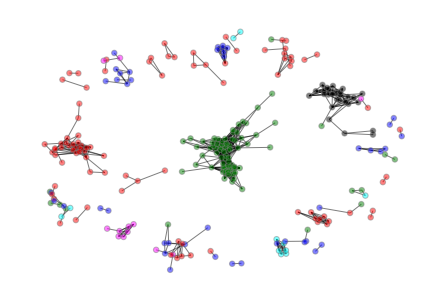

In [188]:
import networkx as nx
import matplotlib.pyplot as plt
from tcrdist.html_colors import get_html_colors

# <G> Initialize a networkx Graph instance from the columns of df_net.
G = nx.from_pandas_edgelist(pd.DataFrame({'source' : df_net['node_1'],
                                          'target' : df_net['node_2'],
                                          'weight' : df_net['weight']}))

# Assign each node a color based on its epitope annotation.
epitopes = ['A01_TTD', 'A02_YLQ', 'A01_LTD', 'B15_NQK', 'A01_FTS', 'A24_NYN']
# Get the same nunber of colors as unique epitopes
colors   = get_html_colors(len(epitopes))
# Construct a dictionary to lookup color by epitope.
color_by_epitope = {epitope: color for epitope,color in zip(epitopes,colors)}
# Assign colors to each node based on its epitope annotation.
node_colors = {node: color_by_epitope.get(epitope) for node, epitope in 
               zip(df_net['node_1'],df_net['epitope_1'])}
# Positions for all nodes according to a spring layout.
pos = nx.spring_layout(G, seed=2, k = .15, weight = 'weight')  
# Define aesthetic options
options = {"edgecolors": "tab:gray", "node_size": 30, "alpha": 0.5}
nx.draw(G, 
        nodelist = G.nodes, 
        pos = pos, 
        node_color= [node_colors[node] for node in G.nodes],
        **options)
plt.savefig("Fig1.pdf")

**Caption Network of TCRdistances <= 120 among TCRs annotated with 1 of 6 immunodominant SARS-CoV2 epitopes identified in Minervina and Pogorelyy et al., 
(2021). The node colors correspond to A*01 FTS (magenta), A*01_LTD (blue) A*01_TTD (red), A*02_YLQ (green), A*24_NYN (black), and B*15_NQK (cyan), The network edges shown are those formed between TCRs in different participants, emphasizing the public nature of the sequence similarity.**

The network in **Figure 1** illustrates a now well recognized feature of TCR biology: biochemically similar TCRs often recognize the same epitope. In the proceeding step, we more closely examine clusters of TCRs annotated to bind the A*02 YLQ pMHC multimer (shown in Figure 1 as the cluster of green nodes).

### Networks Among A*02 YLQ Annotated TCRs

To keep things tidy, we repeat the data import and cleanup steps that we previously introduced above. However, now we subset to focus on TCRs specific for A*02_YLQ. Note the line `df = df[ df['epitope'].isin(epitopes)].reset_index(drop = True)` will select only those TCRs specified in the `epitopes` list, which we have populated with `A02_YLQ`. We leave it as an exercise for the reader to investigate other clusters of TCRs by changing line 10.

In [189]:
import os 
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from tcrdist.repertoire import TCRrep

path = 'data'
f = 'clonotypes_minervina.tsv'
# Note only the A*02 YLQ epitope will be considered
epitopes = ["A02_YLQ"] 

edge_threshold = 120

df = pd.read_csv(f, sep = "\t")
df = df[ df['epitope'].\
        isin(epitopes)].\
        reset_index(drop = True)

# Rename columns.        
df = df.rename(columns = {
    'cdr3b':'cdr3_b_aa', 
    'vb':'v_b_gene', 
    'jb': 'j_b_gene',
    'cdr3a':'cdr3_a_aa', 
    'va': 'v_a_gene', 
    'ja' :'j_a_gene',
    'donor':'subject'} )

# Add *01 allele level designation.
df['v_a_gene']  = df['v_a_gene'].apply(lambda x: f"{x}*01")
df['v_b_gene']  = df['v_b_gene'].apply(lambda x: f"{x}*01")
df['j_a_gene']  = df['j_a_gene'].apply(lambda x: f"{x}*01")
df['j_b_gene']  = df['j_b_gene'].apply(lambda x: f"{x}*01")
df['count'] = 1

# <tr> Initialize TCRrep instance.                       
tr = TCRrep(cell_df = df[['subject','epitope','cdr3_a_aa',
                          'v_a_gene','j_a_gene','cdr3_b_aa',
                          'v_b_gene','j_b_gene','category',
                          'count','cdr3a_nt','cdr3b_nt']] , 
    organism = 'human', 
    chains = ['alpha','beta'],
    deduplicate = True,
    compute_distances = True)

# Identiy edges among A*02 YLQ annotated TCRs.
network = list()
for i,n in enumerate(_neighbors_fixed_radius(tr.pw_beta+tr.pw_alpha, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                (tr.pw_beta + tr.pw_alpha)[i,j]    # 'dist'- gets the distance between TCR(i,j)
            ))
        
cols = ['node_1', 'node_2', 'dist'] 
df_net = pd.DataFrame(network, columns = cols)
df_net['weight'] = edge_threshold - df_net['dist']

By representing the network as a `networkx` graph object, we can then apply the Louvain community identification algorithm in the python `community` package to identify grouping of highly networked TCRS within the set of A*02 YLQ - specific TCRs.

In [190]:
import networkx as nx
import community.community_louvain as community_louvain
G = nx.from_pandas_edgelist(pd.DataFrame({'source' : df_net['node_1'],'target' : df_net['node_2'], 'weight' :df_net['weight']}))
partition= community_louvain.best_partition(G, random_state = 1)

A shortcoming of the output returned from the `community_louvain` function is that the cluster identification numbers don't correspond to the size of the clusters. Before proceeding, we re-assign cluster numbers such that `0` corresponds with the largest cluster, `1` with the second largest cluster, and so on.

In [191]:
# Change partition such that cluster Id is in descending order based on community size 
partitions_by_cluster_size = list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {id:rank for id,rank in zip(partitions_by_cluster_size, 
                                                range(len(partitions_by_cluster_size)))}
partition = {k:partition_reorder.get(v) for k,v in partition.items()}

We visualize the TCR network. We specify the node colors according to community membership identified by the Louvain algorithm.

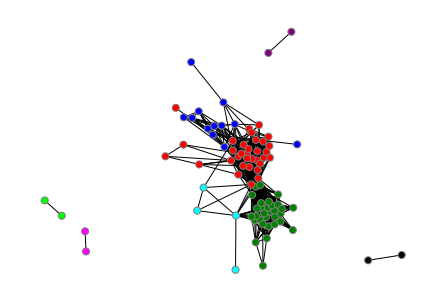

In [192]:
from tcrdist.html_colors import get_html_colors
clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors   = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": "tab:gray","node_size": 50}
pos = nx.spring_layout(G, seed=2, k = .3, weight= 'weight') 
nx.draw(G, nodelist = G.nodes, pos = pos, node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes], **options)
plt.savefig("Fig2.pdf")

**Figure 2 Network of TCRdistances <= 120 among TCRs annotated with SARS-CoV2 epitopes A*02 YLQ.**  Minervina and Pogorelyy et al., 2021 annotated these paired chain receptors as recognizing A*02 based on DNA-labeled pMHC dextramers.  The colors red, green, blue, lime, black, magenta, and cyan map in descending order by cluster size.

### A*02 YLQ Clusters Gene Usage

Tcrdist3 contain a visualization tool to generate custom Sankey SVG diagrams showing frequency of gene-usage and gene-pairings. This enables the user to identify different Va, Ja, Vb, and Jb gene pairings within any user-specified TCR set.

In [ ]:
import IPython
from tcrdist import plotting
clone_df_ylq = tr.clone_df.copy()
clone_df_ylq['cluster_alpha_beta'] = [str(partition.get(i)) if partition.get(i) is not None else None for i in clone_df_ylq.index]

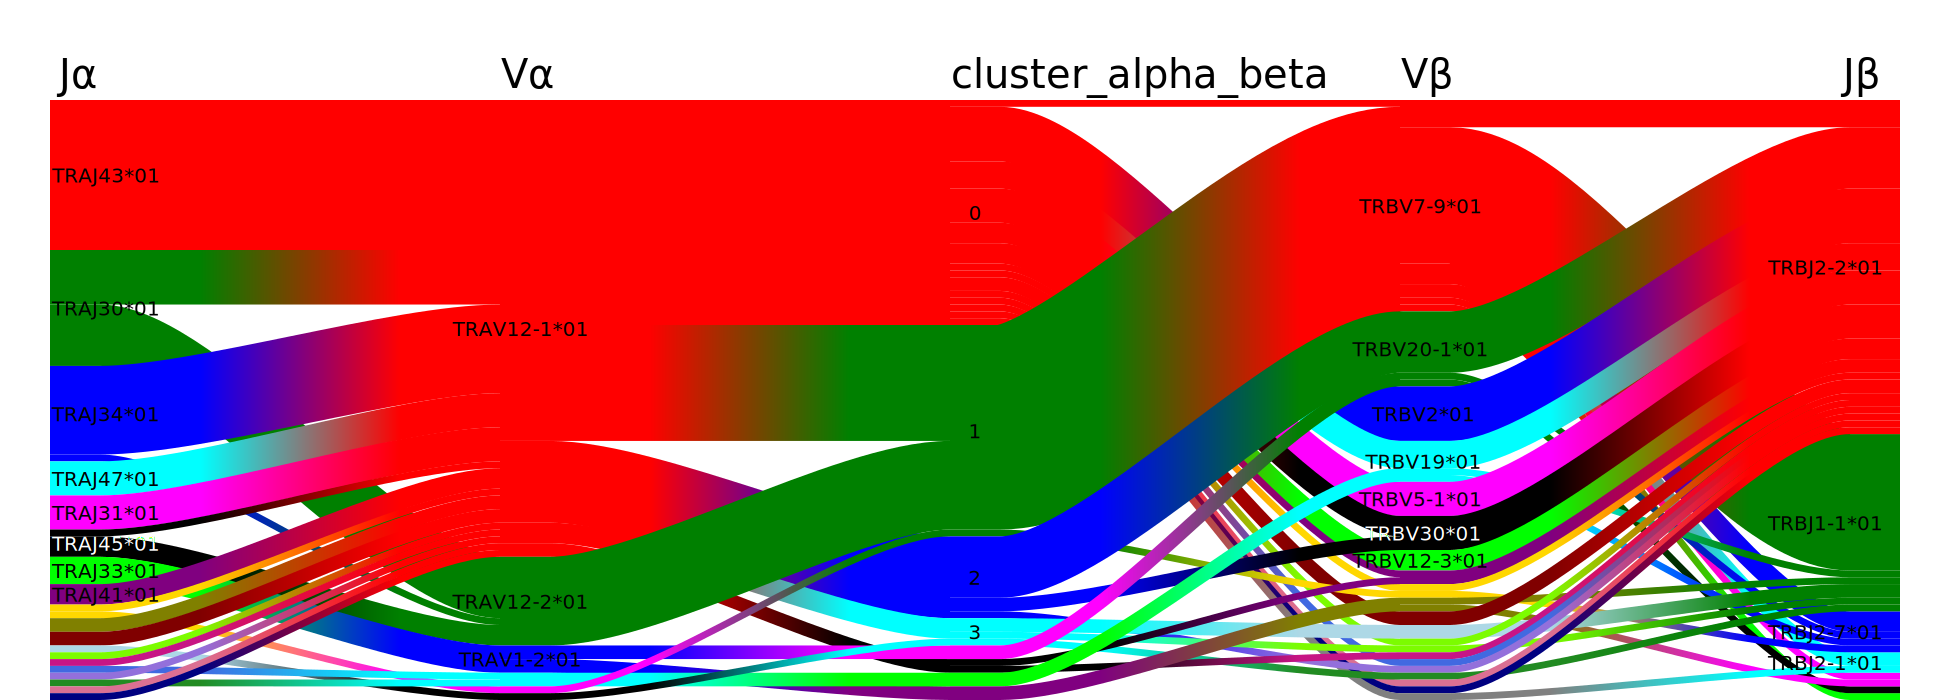

In [ ]:
import IPython
from tcrdist import plotting
# Note that not all clones were part of the network so subset to those 
# that are .notna()
clone_df_ylq_clustered = clone_df_ylq[clone_df_ylq.cluster_alpha_beta.notna()]

svg = plotting.plot_pairings(cell_df = clone_df_ylq_clustered,
                             cols = ['j_a_gene','v_a_gene',
                                     'cluster_alpha_beta', 
                                     'v_b_gene' ,'j_b_gene'],
                             count_col='count')
IPython.display.SVG(data=svg)

**Figure 3A**

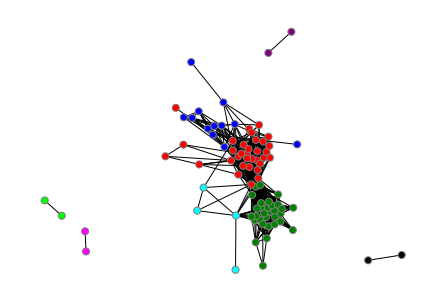

In [ ]:
nx.draw(G, nodelist = G.nodes, pos = pos, node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes], **options)

**Figure 3B**

**Figure 3. (A) Sankey plot showing Ja-Va-Vb-Jb gene pairings in all TCRs comprising the multiple identified clusters among the A*02_YLQ annotated TCRs (B) Network diagram of A*02_YLQ annotated TCRs are joined by edges less than 120 TCRdist units. The color of the clusters in the nework match the 'cluster_alpha_beta' column in the Sankey plot**

Visualizing the network representation alongside the gene-usage plot can be helpful. Colors (red, green, and blue) represent the 1st, 2nd, and 3rd largest clusters respectively. The cluster_alpha_beta column is color-matched to the network diagram above. By inspection, we notice that the most abundant cluster_alpha_beta (cluster 0 - red) is defined by the exclusive use of TRAV12-1 and TRAJ43 or TRAJ30 genes. We can also see that TRAV12-1 alpha-chains within this cluster pair with beta-chains formed from VDJ junctions involving many different TRBV genes (TRBV2, TRBV19, TRBV30, TRBV5-1, TRBV12-3, and others). By contrast, the 2nd most abundant cluster_alpha_beta (cluster 1 - green) is comprised of TCRs nearly exclusively formed from TRBV7-9/TRBJ1-1 beta-recombination, with an alpha chain using either TRAV12-2 or TRAV12-1. 

This is potential evidence that the modes of binding achieved by TCRs in these two clusters likely differ. In cluster 0 (red), the high diversity of TRBV genes implies that some degree of specificity is likely conferred by contacts in the alpha chain or portions of the CDR3 contributed by the TRBJ-gene. Thus, in cluster 0 (red) interactions between the TRBV CDR1, CDR2, CDR2.5 and the A02 MHC are likely minimally important compared to in cluster 1 (green) where these beta CDRs might have a larger role in stabilizing the molecular interaction. A third cluster ( cluster 2 - blue), although having less TRBV gene diversity than cluster 0 (red), may share a similar binding conformation to cluster 0, given that all members of this cluster also use TRAV12-1 to form a functional receptor.

#### Gene Usage with Sankey Diagrams 

With tcrdist3, it is immediately feasible to see each cluster's gene usage in isolation, as shown below by querying only the portion of the clone_df corresponding with a particular clusters of interest (Figure 4 and 5)

In [ ]:
with open("YLQ_clusters.svg", 'w') as oh:
    oh.write(svg)

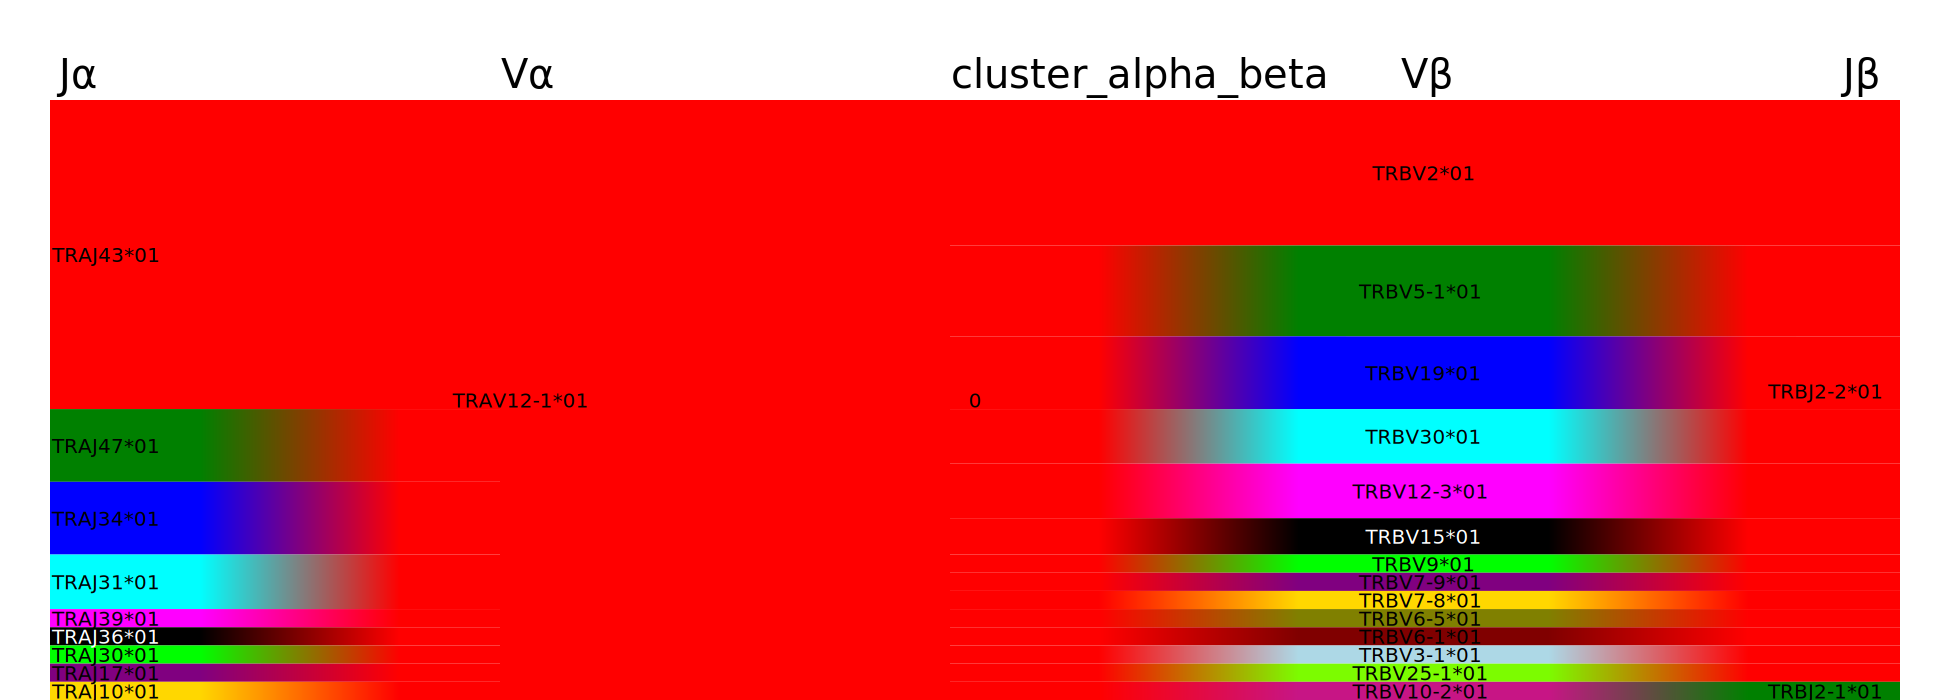

In [ ]:
import IPython
from tcrdist import plotting
cluster_df =  clone_df_ylq.query("cluster_alpha_beta == '0'")
svg = plotting.plot_pairings(cell_df = cluster_df,
                             cols = ['j_a_gene','v_a_gene','cluster_alpha_beta', 'v_b_gene' ,'j_b_gene'],
                             count_col='count')
IPython.display.SVG(data=svg)

**Figure 4: Sankey plot showing Ja-Va-Vb-Jb gene pairings in all TCRs comprising the largest cluster (cluster 0) of A*02_YLQ annoated TCRs**

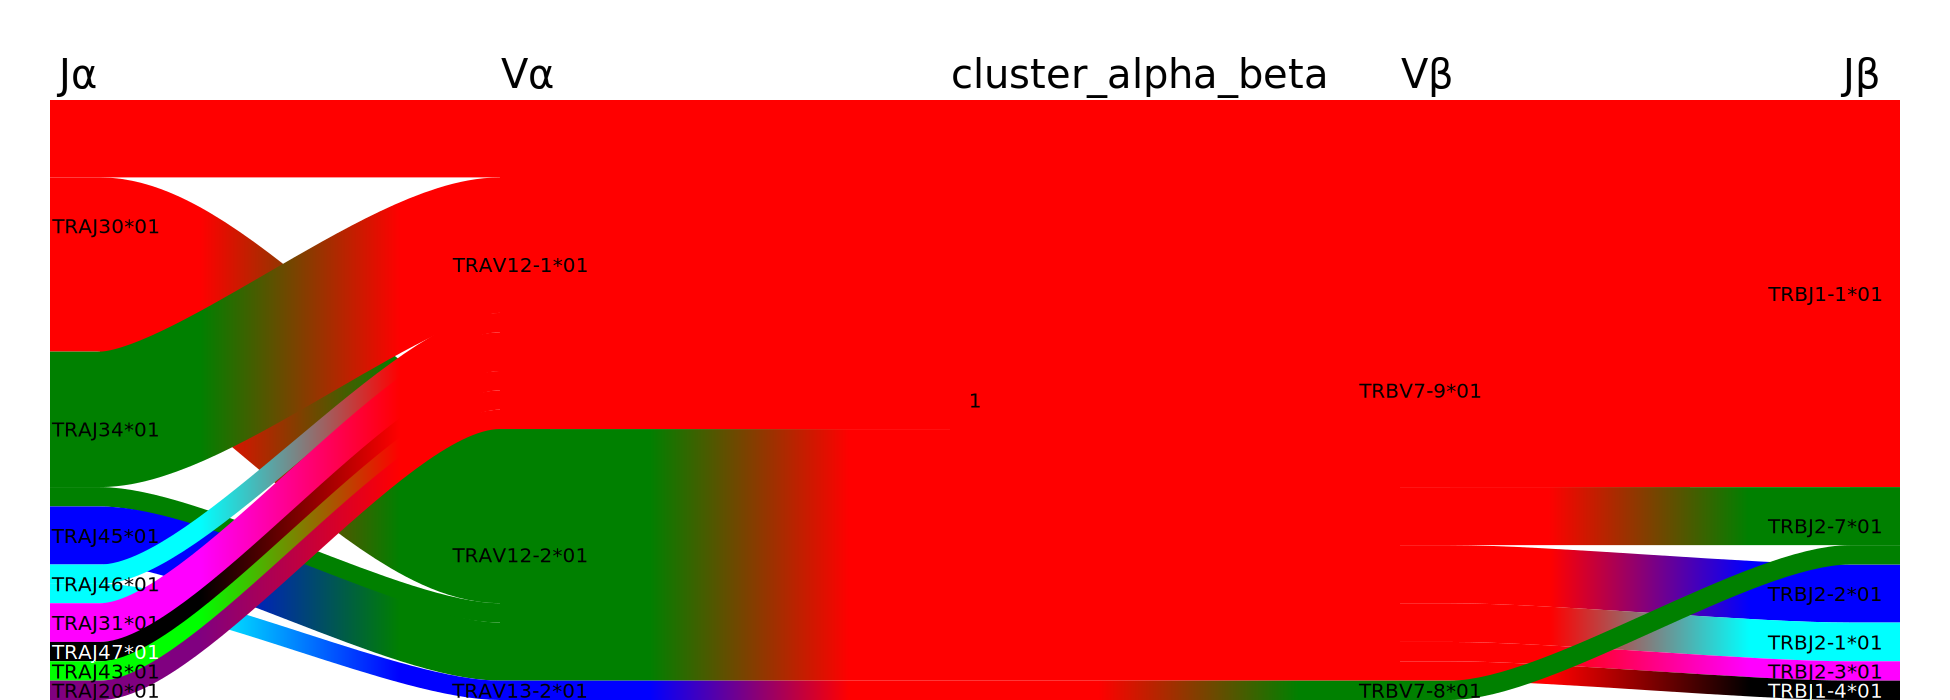

In [ ]:
import IPython
from tcrdist import plotting
cluster_df =  clone_df_ylq.query("cluster_alpha_beta == '1'")
svg = plotting.plot_pairings(cell_df = cluster_df,
                             cols = ['j_a_gene','v_a_gene','cluster_alpha_beta', 'v_b_gene' ,'j_b_gene'],
                             count_col='count')
IPython.display.SVG(data=svg)

**Figure 5: Sankey plot showing Ja-Va-Vb-Jb gene pairings in all TCRs comprising the largest cluster (cluster 0) of A*02_YLQ annoated TCRs**

### Background Subtracted CDR3 Logo Motifs

Through the process of VDJ recombination, CDR3s contain germline-encoded as well as randomly generated amino acids. To visually identify those portions of the motif that are unexpected beyond residues contributed by germline V and J gene segments, tcrdist3 allows users to generate background-subtracted motifs. The package `TCRsampler` facilitates rapid generation of a background set of TCRs that share the same V and J gene usage as the foreground set of TCRs in a cluster of interest. Before proceeding, we must initialize a beta- and alpha-chain sampler. 

If you've not run TCRsampler previously, you will need to download the default background data sets. Downloads occur automatically by running the following command in your terminal. You only need to do this once.

#### Getting Antigen Naive Backgrounds

In [193]:
!python -c "from tcrsampler.setup_db import install_all_next_gen; install_all_next_gen(dry_run = False)"

RUNNING: curl -o /usr/local/lib/python3.7/dist-packages/tcrsampler/db/ravens_samplers.zip https://www.dropbox.com/s/bahxa6x86drq0n5/ravens_samplers.zip?dl=1 -L
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   143    0   143    0     0    448      0 --:--:-- --:--:-- --:--:--   448
100   320  100   320    0     0    440      0 --:--:-- --:--:-- --:--:--   440
100  313k  100  313k    0     0   268k      0  0:00:01  0:00:01 --:--:-- 1751k
Archive:  /usr/local/lib/python3.7/dist-packages/tcrsampler/db/ravens_samplers.zip
replace /usr/local/lib/python3.7/dist-packages/tcrsampler/db/ravens_human_gamma_t.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


#### Initializing TCRsamplers

With default backgrounds downloaded, we proceed to initialize an instance of the TCRsampler object. One sampler is for the beta-chain and will use cord blood from 8 donors (Britanova et al. 2016). For the alpha-chain, we will use pre-computed synthetic TCRs generated with the software OLGA (Sethna et al., 2019) from a generation probability model trained on non-productive TCRs (Marcou et al., 2018). 

In [194]:
from palmotif import compute_pal_motif, svg_logo
from tcrsampler.sampler import TCRsampler   
from tcrdist.regex import  _matrix_to_regex
# This step can take up to 1 minute, so be patient
ts_beta = TCRsampler(default_background = 'britanova_human_beta_t_cb.tsv.sampler.tsv')
ts_beta.build_background(max_rows = 50, stratify_by_subject = True)
ts_alpha = TCRsampler(default_background = 'olga_human_alpha_t.sampler.tsv')
ts_alpha.build_background(max_rows = 50, stratify_by_subject = True)

How does TCRsampler work? With a large set of TCRs loaded into memory for most V-J pairings, the method `TCRsampler.sample` quickly returns randomly sampled CDR3 based on the user's specified V J pairings. It returns a list of CDR3s with the same ratio of gene usages as the input. For instance, suppose you have a set of 3 TCRs (1 with 'TRBV10-2*01'+'TRBJ2-1*01' and 2 with 'TRBV15*01'+'TRBJ2-1*01'). `TCRsampler.sample` returns a set of 3 random CDRs with the same gene usage as follows: 

In [ ]:
ts_beta.sample([['TRBV10-2*01','TRBJ2-1*01',1], ['TRBV15*01','TRBJ2-1*01',2]])

[['CASSSGLAIGNEQFF'], ['CATSRDSYEQFF', 'CATSRDLDYAFNEQFF']]

In practice, a larger background with many V- and J-matched random CDR3 sequences is required. By setting the `depth = x` argument, more CDR3s are returned, where x is the multiple by which the background will be deeper than the input list. 

In [ ]:
ts_beta.sample([['TRBV10-2*01','TRBJ2-1*01',1], ['TRBV15*01','TRBJ2-1*01',2]], depth = 2)

[['CASSSGLAIGNEQFF', 'CARDRGQFF'],
 ['CATSRDSYEQFF', 'CATSRDLDYAFNEQFF', 'CATSRATSGRSSEQFF', 'CATSRDRSYEQFF']]

Notice that the ratio of gene usage stays the same but the size of the background increases. To get all the CDR3s as a single list, choose the `flatten = True` argument. When TCRsampler cannot find any TCRs matching a particular V- and J-gene pairing, it will return None.

In [ ]:
ts_beta.sample([['TRBV10-2*01','TRBJ2-1*01',1], ['TRBV15*01','TRBJ2-1*01',2]], depth = 3, flatten = True)

['CASSSGLAIGNEQFF',
 'CARDRGQFF',
 'CASSLLYNEQFF',
 'CATSRDSYEQFF',
 'CATSRDLDYAFNEQFF',
 'CATSRATSGRSSEQFF',
 'CATSRDRSYEQFF',
 'CATSRGTGGNEQFF',
 'CATSRDVPSLRFF']

Suppose we want to generate a deeper background for a specific cluster. First create a dataframe that contains only clones where alpha_beta_cluster cluster id is '0'.

In [ ]:
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq['cluster_alpha_beta'] == cluster_id]

Next, create gene usage information in the format the TCRsampler recognizes (i.e., a list of lists each with three parts specifying the (i) V-gene, (ii) J-gene, and (iii) count. Do this once for the alpha-receptors and once for the beta-receptors.

In [ ]:
gene_usage_alpha = cluster_df.groupby(['v_a_gene','j_a_gene']).size().reset_index().to_dict('split')['data']
gene_usage_alpha

[['TRAV12-1*01', 'TRAJ10*01', 1],
 ['TRAV12-1*01', 'TRAJ17*01', 1],
 ['TRAV12-1*01', 'TRAJ30*01', 1],
 ['TRAV12-1*01', 'TRAJ31*01', 3],
 ['TRAV12-1*01', 'TRAJ34*01', 4],
 ['TRAV12-1*01', 'TRAJ36*01', 1],
 ['TRAV12-1*01', 'TRAJ39*01', 1],
 ['TRAV12-1*01', 'TRAJ43*01', 17],
 ['TRAV12-1*01', 'TRAJ47*01', 4]]

In [ ]:
gene_usage_beta = cluster_df.groupby(['v_b_gene','j_b_gene']).size().reset_index().to_dict('split')['data']
gene_usage_beta

[['TRBV10-2*01', 'TRBJ2-1*01', 1],
 ['TRBV12-3*01', 'TRBJ2-2*01', 3],
 ['TRBV15*01', 'TRBJ2-2*01', 2],
 ['TRBV19*01', 'TRBJ2-2*01', 4],
 ['TRBV2*01', 'TRBJ2-2*01', 8],
 ['TRBV25-1*01', 'TRBJ2-2*01', 1],
 ['TRBV3-1*01', 'TRBJ2-2*01', 1],
 ['TRBV30*01', 'TRBJ2-2*01', 3],
 ['TRBV5-1*01', 'TRBJ2-2*01', 5],
 ['TRBV6-1*01', 'TRBJ2-2*01', 1],
 ['TRBV6-5*01', 'TRBJ2-2*01', 1],
 ['TRBV7-8*01', 'TRBJ2-2*01', 1],
 ['TRBV7-9*01', 'TRBJ2-2*01', 1],
 ['TRBV9*01', 'TRBJ2-2*01', 1]]

Use the gene usage to generate backgrounds of CDR3s for both the alpha and beta chain.

In [ ]:
sampled_rep_alpha = ts_alpha.sample(gene_usage_alpha, flatten = True, depth = 100)
# remove any None values that could have been generated by unknown pairs
sampled_rep_alpha =  [x for x in sampled_rep_alpha if x is not None]

sampled_rep_beta = ts_beta.sample(gene_usage_beta , flatten = True, depth = 100)
# remove any None values that could have been generated by unknown pairs
sampled_rep_beta =  [x for x in sampled_rep_beta if x is not None]

/usr/local/lib/python3.7/dist-packages/tcrsampler/sampler.py:426: UserWarning: (TRBV12-3*01,TRBJ2-2*01 gene usage not available
  warnings.warn(f"({v},{j} gene usage not available")


#### SVG Logo Motifs

With a relevant V-J gene matched background, we can generate aligned background substrated logo motif with the functions `compute_pal_motif` and `svg_logo` functions in the `palmotif` package. By aligning both foreground and background CDR3s to a centroid sequence we can attempt to identify residues that are more common in antigen-specific TCR sets. To identify critical residues, we constructed a logo plot of all TCR CDR3 amino acid sequences from cluster 0, together with a “background-adjusted” logo plot. The background-adjusted plot shows the position-specific Kullback-Leibler divergence from an alignment of background CDR3s that were sampled from cord blood (beta) and synthesized from a probabilistic model (alpha) constrained to use the same V and J genes. It emphasizes the uncommon amino acid residues in the clonotype, reducing the size in particular of residues encoded by the germline V and J genes. By specifying `refs = None` a raw logo is generated. Comparison of the background-adjusted logo to the raw logo beneath it allows for simultaneous appreciation of the most common residues with those that are under the strongest selection. For example, in the alpha logos below, the first N is both highly conserved across the receptor pool, but also unlikely given the background receptor distribution. 

In [ ]:
# ALPHA CHAIN
motif, stat = compute_pal_motif(
    seqs = cluster_df['cdr3_a_aa'].to_list(),
    refs = sampled_rep_alpha, 
    centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])
background_subtracted_svg_alpha = svg_logo(motif, return_str= True).\
  replace('height="100%"', 'height="20%"').\
  replace('width="100%"', 'width="20%"')
motif_raw, stat_raw = compute_pal_motif(
    seqs = cluster_df['cdr3_a_aa'].to_list(),
    refs = None,
    centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])
raw_svg_alpha = svg_logo(motif_raw, return_str= True).\
  replace('height="100%"', 'height="20%"').\
  replace('width="100%"', 'width="20%"')
regex_alpha =  _matrix_to_regex(motif_raw,max_ambiguity=5, ntrim=0, ctrim=0)
# BETA CHAIN
motif, stat = compute_pal_motif(
    seqs = cluster_df['cdr3_b_aa'].to_list(),
    refs = sampled_rep_beta, 
    centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])
background_subtracted_svg_beta = svg_logo(motif, return_str= True).\
    replace('height="100%"', 'height="20%"').replace('width="100%"', 'width="20%"')
motif_raw, stat_raw = compute_pal_motif(
    seqs = cluster_df['cdr3_b_aa'].to_list(),
    refs = None,
    centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])
raw_svg_beta = svg_logo(motif_raw, return_str= True).\
    replace('height="100%"', 'height="20%"').replace('width="100%"', 'width="20%"')
regex_beta =  _matrix_to_regex(motif_raw, max_ambiguity=5, ntrim=0, ctrim=0)

Here we've displayed the svg graphics using a small about of html code. If the `svg_logo` function is run with `return_str = False` and `filename="output_name.svg"`, it can be used to write SVG vector graphics directly to a file for use in publication graphics. 

In [ ]:
from IPython.core.display import display, HTML
no_wrap_div = '<div><h3>Cluster {}</h3><h5>_________alpha CDR3 Logo {}_________'\
'beta CDR3 Logo {}________________________</h5></div>'\
'<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'
display(HTML(no_wrap_div.format(cluster_id, regex_alpha,regex_beta, background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta)))

In [ ]:
no_wrap_div = '<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'
with open("Fig 6.html",'w') as oh:
  oh.write(no_wrap_div.format(background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta))

**Figure 6. Background-subtracted CDR3 αβ logo plots of A*02_YLQ cluster 0**

Similarly, we can follow the same procedure to visualize any cluster, simply by changing the cluster_id variable.We can follow the same procedure to visualize more clusters by changing the cluster_id variable. Users may wrap their custom routine in a function to generate many logos. 

In [ ]:
from IPython.core.display import display, HTML
from palmotif import compute_pal_motif, svg_logo
from tcrsampler.sampler import TCRsampler   
from tcrdist.regex import  _matrix_to_regex

# Select the cluster to subset, selecting `1` instead of `0` in the 
# previous example.
cluster_id = '1'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id]

def custom_logo_routine(cluster_df, label):
  # Identify the gene usage pattern for the alpha and beta chains
  gene_usage_alpha = cluster_df.groupby(['v_a_gene','j_a_gene']).\
      size().\
      reset_index().\
      to_dict('split')['data']
  gene_usage_beta = cluster_df.groupby(['v_b_gene','j_b_gene']).\
      size().\
      reset_index().\
      to_dict('split')['data']

  # ALPHA
  # Sample a background for the alpha chain
  sampled_rep_alpha = ts_alpha.sample(gene_usage_alpha, flatten = True, depth = 100)
  # Remove any None values that could have been generated by unknown pairs
  sampled_rep_alpha =  [x for x in sampled_rep_alpha if x is not None]
  # Compute background subtracted positionally aligned motif logo
  motif, stat = compute_pal_motif(
      seqs = cluster_df['cdr3_a_aa'].to_list(),
      refs = sampled_rep_alpha, 
      centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])
  # Compute raw positionally aligned motif logo
  background_subtracted_svg_alpha = svg_logo(motif, return_str= True).\
    replace('height="100%"', 'height="20%"').\
    replace('width="100%"', 'width="20%"')
  # Compute raw positionally aligned motif logo
  motif_raw, stat_raw = compute_pal_motif(
      seqs = cluster_df['cdr3_a_aa'].to_list(),
      refs = None,
      centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])
  raw_svg_alpha = svg_logo(motif_raw, return_str= True).\
    replace('height="100%"', 'height="20%"').\
    replace('width="100%"', 'width="20%"')
  # Generate a regeular expression from the pal motif matrix
  regex_alpha =  _matrix_to_regex(motif_raw,max_ambiguity=5, ntrim=0, ctrim=0)

  # Reapeat for the the BETA chain 
  # Sample a background for the beta chain
  sampled_rep_beta = ts_beta.sample(gene_usage_beta, flatten = True, depth = 100)
  # remove any None values that could have been generated by unknown pairs
  sampled_rep_beta =  [x for x in sampled_rep_beta if x is not None]

  # Compute background subtracted positionally aligned motif logo
  motif, stat = compute_pal_motif(
      seqs = cluster_df['cdr3_b_aa'].to_list(),
      refs = sampled_rep_beta, 
      centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])
  background_subtracted_svg_beta = svg_logo(motif, return_str= True).\
      replace('height="100%"', 'height="20%"').\
      replace('width="100%"', 'width="20%"')
  # Compute raw positionally aligned motif logo
  motif_raw, stat_raw = compute_pal_motif(
      seqs = cluster_df['cdr3_b_aa'].to_list(),
      refs = None,
      centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])
  raw_svg_beta = svg_logo(motif_raw, return_str= True).\
      replace('height="100%"', 'height="20%"').\
      replace('width="100%"', 'width="20%"')
  regex_beta =  _matrix_to_regex(motif_raw, max_ambiguity=5, ntrim=0, ctrim=0)

  # Output the results as tidy html
  no_wrap_div = '<div><h3>{}</h3><h5>_________alpha CDR3 Logo {}________'\
'beta CDR3 Logo {}________________________</h5></div>'\
'<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'
  display(HTML(no_wrap_div.format(label, 
                                  regex_alpha,regex_beta, 
                                  background_subtracted_svg_alpha, 
                                  background_subtracted_svg_beta, 
                                  raw_svg_alpha,raw_svg_beta)))
  return (background_subtracted_svg_alpha,
          background_subtracted_svg_beta ,
          raw_svg_alpha,
          raw_svg_beta)

custom_logo_routine(cluster_df = cluster_df, label = "Cluster 1")

('<svg baseProfile="full" height="20%" version="1.1" viewBox="0 0 1258.000000 557.439212" width="20%" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><g id="0_C" transform="translate(104 403.83010415782616) scale(1 0.021212653552938377)"><path d="M 100 28 C 100 -13 0 -13 0 50 C 0 113 100 113 100 72 L 75 72 C 75 90 30 90 30 50 C 30 10 75 10 75 28 L 100 28" fill="green" /></g><g id="1_G" transform="translate(208 395.89013457460044) scale(1 0.10061234938519525)"><path d="M 100 28 C 100 -13 0 -13 0 50 C 0 113 100 113 100 72 L 100 48 L 55 48 L 55 72 L 75 72 C 75 90 30 90 30 50 C 30 10 75 5 75 28 L 100 28" fill="green" /></g><g id="1_V" transform="translate(208 380.06034302544776) scale(1 0.15829791549152694)"><path d="M 0 0 L 20 0 L 50 80 L 80 0 L 100 0 L 60 100 L 40 100 L 0 0" fill="black" /></g><g id="1_A" transform="translate(208 409.95136951311997) scale(1 0.005649221586054286)"><path d="M 0 100 L 33 0 L 

In [ ]:
background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta = custom_logo_routine(cluster_df = cluster_df, label = "Cluster 1")
no_wrap_div = '<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'
with open("Fig 7.html",'w') as oh:
  oh.write(no_wrap_div.format(background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta))

The cluster one beta chain logos identify the "PDI" motif as highly conserved across the cluster and non-germline encoded.

**Figure 7. Background-subtracted CDR3 αβ logo plots of A*02_YLQ cluster 1**

#### Compute raw positionally aligned motif logo
Tcrdist3 permits the generation of logos from any set of TCRs or clustering methods and the modular nature of tcrdist3 permits the user flexibility to provide any set of background CDRs to the `refs` argument that might be most appropriate. For instance, a tissue-specific, HLA-matched/mismatched, or strain-specific background could be used. Note that `TCRsampler` will issue a warning when a particular VJ gene pair is not available in the reference set. In most cases, logos can be generated using the sample of CDR3s from the remaining pairings.  The user may also wish to select only those CDR3s of the same length ranges as the set being evaluated, which can be easily accomplished as follows:

In [ ]:
max_cdr3_len = cluster_df['cdr3_b_aa'].str.len().max()
min_cdr3_len = cluster_df['cdr3_b_aa'].str.len().min()
sampled_rep_beta = [x for x in sampled_rep_beta if len(x) >= min_cdr3_len and len(x) <= max_cdr3_len]

# 2 : Finding Biochemically Similar TCRs in Bulk Data

Thus far, we've shown how tcrdist3 can be used to interrogate a relatively small number of antigen-specific TCRs that were already annotated by barcoded dextramers. Tcrdist3 is also useful for finding similar TCRs in larger unannotated sets of TCRs that might come from a tissue or patient population of interest. For instance, we might be curious whether the TCRs found in cluster 0 (A*02:01:YLQ) are commonly detectable in unenriched repertoires from COVID-19 patients in the context of natural infection. Suppose we want to see whether there are similar TCRs to those we identified in cluster 0 (Minervina et al 2021). Here we consider some additional single-cell TCR data from (
Ren X, Wen W, Fan X, Hou W et al. COVID-19 immune features revealed by a large-scale single-cell transcriptome atlas. Cell 2021 Apr 1;184(7):1895-1913.e19. PMID: 33657410).

### Preprocessing

In [ ]:
import os 
import pandas as pd
import numpy as np
from tcrdist.repertoire import TCRrep
from tcrdist.breadth import get_safe_chunk
from tcrdist.join import join_by_dist

In [ ]:
# Check that file for example 2 available. If not, download it.
import os 
f = 'GSE158055_covid19_tcr_vdjnt_pclone.tsv.gz'
if not os.path.isfile(f):
  os.system('wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/GSE158055_covid19_tcr_vdjnt_pclone.tsv.gz')
# Make a folder 'data' where some outputs will be written
path = 'data'
if not os.path.isdir(path):
  os.mkdir(path)

In [ ]:
# Preprocess the data from Ren et al., 2021
columns = {'PatientID'  :'subject',
           'TCRA_vgene' :'v_a_gene',
           'TCRA_jgene' : 'j_a_gene',
           'TCRA_cdr3aa':'cdr3_a_aa',
           'TCRB_vgene' :'v_b_gene',
           'TCRB_jgene' :'j_b_gene',
           'TCRB_cdr3aa':'cdr3_b_aa',
           'TCR_pclone.freq':'count'}
f ='/content/GSE158055_covid19_tcr_vdjnt_pclone.tsv.gz' 
ren = pd.read_csv(f, sep = '\t')
ren = ren[columns.keys()].\
    rename(columns = columns)
ren['v_b_gene'] = ren['v_b_gene'].apply(lambda x: f"{x}*01")
ren['v_a_gene'] = ren['v_a_gene'].apply(lambda x: f"{x}*01")
ren['j_b_gene'] = ren['j_b_gene'].apply(lambda x: f"{x}*01")
ren['j_a_gene'] = ren['j_a_gene'].apply(lambda x: f"{x}*01")
ren.head(5)

,subject,v_a_gene,j_a_gene,cdr3_a_aa,v_b_gene,j_b_gene,cdr3_b_aa,count
0,P-M044,TRAV4*01,TRAJ34*01,CLVDLYNTDKLIF,TRBV20-1*01,TRBJ2-7*01,CSATWRRRESPYEQYF,1
1,P-M044,TRAV13-2*01,TRAJ8*01,CAEMENTGFQKLVF,TRBV16*01,TRBJ2-2*01,CASSQLSPGPRNTGELFF,145
2,P-M044,TRAV13-2*01,TRAJ8*01,CAEMENTGFQKLVF,TRBV16*01,TRBJ2-2*01,CASSQLSPGPRNTGELFF,145
3,P-M044,TRAV1-2*01,TRAJ20*01,CAVRDGDYKLSF,TRBV20-1*01,TRBJ2-1*01,CSARPGLASYNEQFF,1
4,P-M044,TRAV13-2*01,TRAJ8*01,CAEMENTGFQKLVF,TRBV16*01,TRBJ2-2*01,CASSQLSPGPRNTGELFF,145


### Search for Exact CDR3αβ  Matches

First, we might consider whether there are matching CDR3 alpha and CDR3 beta-amino acids sequences. We find that there are none.

In [ ]:
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id].reset_index(drop = True)
cluster_df[['v_a_gene','cdr3_a_aa', 'v_b_gene','cdr3_b_aa']].\
    merge(ren, how = "inner" , on = ['cdr3_b_aa','cdr3_b_aa'])

,v_a_gene_x,cdr3_a_aa_x,v_b_gene_x,cdr3_b_aa,subject,v_a_gene_y,j_a_gene,cdr3_a_aa_y,v_b_gene_y,j_b_gene,count


### Finding Similar Non-Identical TCRs in Bulk Repertoires
A common objective is to compute distances between TCRs in one, often small, 'search' set against a second, often much larger, 'bulk' set of TCRs. In these cases, a large "rectangular" distance matrix is desired. Tcrdist3 makes this easy, with the `compute_rect_distances()` method. The first argument `df` specifies the primary DataFrame of clones to correspond to rows and `df2` specifies the secondary DataFrame that will correspond to the columns of the resulting "rectangular" distance matrix.

`TCRrep.compute_rect_distances(df = tr_search.clone_df, df2 = tr_bulk.clone_df)`

When `compute_rect_distances`is called, the resulting attributes will be generated:
* `TCRrep.rw_beta` 
* `TCRrep.rw_alpha`, 
* `TCRrep.rw_cdr3_b_aa`, and 
* `TCRrep.rw_cdr3_a_aa`  containing full np.arrays(). 

To be clear, the entries of the np.arrays, will have row indices aligning to rows of the primary DataFrame and columns aligning that align to rows of the secondary pandas.DataFrame. 

However, as the number of pairwise comparisons exceeds 100 million (i.e., what one might generate with 100 search clones 10^2 x 1 million bulk clones 10^6), the memory demand increases rapidly. In practice, the relevant distances for subsequent analyses are usually only a small subset of all possible comparisons. Thus, tcrdist3 takes advantage of `scipy.sparse.csrmat` format to store only those distances that are less than or equal to some user-specified threshold distance, as specified by the `radius` argument in: 

`TCRrep.compute_sparse_rect_distances(df = tr_search.clone_df, df2 = tr_bulk.clone_df, radius = 100)`

When storing distances in sparse format, the user should also specify the arguments `chunk_size`, this is the maximum number of rows to compute at a time on each CPU before the desired results are stored in sparse format. As the ideal chunk size depends primarily on the size of the secondary pandas.DataFrame `df2`, we provided a convenience function `get_safe_chunk(tr_search.clone_df.shape[0], tr_bulk.clone_df.shape[0], target = 10**7)` that aims to keep overall distances stored in memory to less than 10 Million.  In practice, it has been our experience that this chunk size permits concurrent use of 6 cpus on a 16 GB laptop without exceeding available memory resources. When the sparse computation is complete the attributes `rw_beta` and `rw_alpha` will be populated with resultant distance in scipy.sparse.csrmat format.  In this sparse format, distances above the threshold are assumed to be zero and are no longer stored in memory. True zero-distances are stored in sparse format, but they are represented as -1. Taking advantage of the sparse format also allows the distance computation to be spread out across multiple CPUs. Just as we formed networks from full pairwise matrices in examples 1 and 2, we can do so directly from scipy.sparse.csrmat matrices ( This is shown via a full example in Appendix A).

With that procedural explanation out of the way, we can proceed to use `.compute_sparse_rect_distances` for the biological task at hand. Recall that we hope to find similar non-identical TCRs in the Ren et al. 2021 dataset of single-cell derived TCRS that are similar to those TCRs comprising cluster 0 of A*02-YLQ specific TCRs annotated in Minervina et al. 2021. 
To do so:
* We instantiate a new TCRrep instance, which we name `tr_search`, passing the cluster 0 clones to the `cell_df` argument
* We set the number of CPUs to 6 or the amount available, whichever is less i.e., `min(6, multiprocessing.cpu_count())`
* We identify an appropriate chunk size
* We then call `.compute_sparse_rect_distances()`

The results will only contain distance between TCRs <= 100 TCR distances units.

In [ ]:
import multiprocessing
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id].reset_index(drop = True)
tr_search =TCRrep(cell_df = cluster_df, 
                  organism = "human", 
                  chains =['alpha','beta'], 
                  deduplicate = False,
                  compute_distances = False,
                  cpus = min(6, multiprocessing.cpu_count()))

tr_bulk = TCRrep(cell_df = ren, 
                 organism = "human", 
                 chains =['alpha','beta'], 
                 deduplicate = False, 
                 compute_distances = False)

chunk_size = get_safe_chunk(tr_search.clone_df.shape[0], tr_bulk.clone_df.shape[0])
tr_search.compute_sparse_rect_distances(
    df = tr_search.clone_df,
    df2 = tr_bulk.clone_df,
    radius = 100,
    chunk_size = chunk_size)

33


The results will only contain distance between TCRs <= 100 TCR distances units. Note that for the beta-chains, we stored 339,499 distance of the more than 8 Million that were actually computed.

In [ ]:
tr_search.rw_beta

<33x220968 sparse matrix of type '<class 'numpy.int16'>'
	with 315629 stored elements in Compressed Sparse Row format>

In [ ]:
tr_search.rw_alpha

<33x220968 sparse matrix of type '<class 'numpy.int16'>'
	with 715426 stored elements in Compressed Sparse Row format>

To aid in understanding, we check that `tr_search.rw_alpha` have the expected dimensions:

In [ ]:
assert tr_search.rw_alpha.shape[0] == tr_search.clone_df.shape[0]
assert tr_search.rw_alpha.shape[1] == tr_bulk.clone_df.shape[0]

However, the number of entries stored in each are not identical.

In [ ]:
assert tr_search.rw_alpha.size != tr_search.rw_beta.size

Thus, we need to use the function `tcrdist.sparse.add_sparse_pwd` if we wish to get combined alpha-beta TCRdist. Only those i,j coordinates with non-zero entries in both sparse matrices will be present in the resulting matrix.

In [ ]:
from tcrdist.sparse import  add_sparse_pwd
tr_search.rw_alpha_beta =  add_sparse_pwd(tr_search.rw_beta,tr_search.rw_alpha)

#### TCRjoin: Table Joins by Distance

Once the sparse matrix has been computed, the function `tcrdist.join.join_by_dist` performs a database-style type join; however, rather than use identical keys it joins rows with TCRs that share a pairwise distance less than the threshold specified by the `radius` argument. For each TCR in the 'left' DataFrame, the function returns up to `max_n` nearest neighbors in the right DataFrame. See the join_by_dist docstrings for more details about all possible options.

In [ ]:
df_join = join_by_dist(
    how = 'inner',
    csrmat = tr_search.rw_alpha_beta ,
    left_df = tr_search.clone_df,
    right_df = tr_bulk.clone_df,
    left_cols  = tr.clone_df.columns.to_list(),
    right_cols = tr_bulk.clone_df.columns.to_list(),
    left_suffix = '_search',
    right_suffix = '_bulk',
    max_n= 1000,
    radius = 120)

If we inspect the resulting DataFrame `df_join`, we can view the closest non-identical matches.

In [ ]:
df_join[['cdr3_a_aa_search','v_a_gene_search', 'j_a_gene_search', 
         'cdr3_b_aa_search','v_b_gene_search', 'j_b_gene_search',
         'cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk',
         'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk','dist','subject_bulk']].\
    query('dist <= 100').\
    sort_values('dist').\
    groupby(['cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk','cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk','subject_bulk']).\
    head(1).reset_index(drop = True).head(10)

,cdr3_a_aa_search,v_a_gene_search,j_a_gene_search,cdr3_b_aa_search,v_b_gene_search,j_b_gene_search,cdr3_a_aa_bulk,v_a_gene_bulk,j_a_gene_bulk,cdr3_b_aa_bulk,v_b_gene_bulk,j_b_gene_bulk,dist,subject_bulk
0,CVVNRRDDMRF,TRAV12-1*01,TRAJ43*01,CASTEGNTGELFF,TRBV12-3*01,TRBJ2-2*01,CVVNREDDMRF,TRAV12-1*01,TRAJ43*01,CAGSEGNTGELFF,TRBV12-3*01,TRBJ2-2*01,21,P-M024
1,CVVNRDNDMRF,TRAV12-1*01,TRAJ43*01,CASQILNTGELFF,TRBV19*01,TRBJ2-2*01,CVVNEVNDMRF,TRAV12-1*01,TRAJ43*01,CASQTLNTGELFF,TRBV19*01,TRBJ2-2*01,36,P-S042
2,CVVNKDDKIIF,TRAV12-1*01,TRAJ30*01,CALSDQNTGELFF,TRBV7-8*01,TRBJ2-2*01,CVVNGDTDKLIF,TRAV12-1*01,TRAJ34*01,CASSRQNTGELFF,TRBV7-8*01,TRBJ2-2*01,42,P-S042
3,CVVNRNNDMRF,TRAV12-1*01,TRAJ43*01,CATQSDPNTGELFF,TRBV2*01,TRBJ2-2*01,CVVNNNNDMRF,TRAV12-1*01,TRAJ43*01,CASISADLNTGELFF,TRBV2*01,TRBJ2-2*01,48,P-M071
4,CVVNRGDKLVF,TRAV12-1*01,TRAJ47*01,CASDDPNTGELFF,TRBV7-9*01,TRBJ2-2*01,CVVNLRTDKLIF,TRAV12-1*01,TRAJ34*01,CCGGDANTGELFF,TRBV7-9*01,TRBJ2-2*01,60,P-M034
5,CVVNRNNDMRF,TRAV12-1*01,TRAJ43*01,CATQDGNTGELFF,TRBV15*01,TRBJ2-2*01,CVVNRDNDMRF,TRAV12-1*01,TRAJ43*01,CATQDSNTGELFF,TRBV10-1*01,TRBJ2-2*01,61,P-S042
6,CVVNNNNDMRF,TRAV12-1*01,TRAJ43*01,CAIEDLNTGELFF,TRBV6-5*01,TRBJ2-2*01,CVVNDNNDMRF,TRAV12-1*01,TRAJ43*01,CASTELNTGELFF,TRBV27*01,TRBJ2-2*01,62,P-M034
7,CVVNNNNDMRF,TRAV12-1*01,TRAJ43*01,CASNEENTGELFF,TRBV5-1*01,TRBJ2-2*01,CVVNNLDDMRF,TRAV12-1*01,TRAJ43*01,CASSLLDTGELFF,TRBV5-1*01,TRBJ2-2*01,63,P-M034
8,CVVNKEDDMRF,TRAV12-1*01,TRAJ43*01,CARGDRNTGELFF,TRBV6-1*01,TRBJ2-2*01,CVVNREDDMRF,TRAV12-1*01,TRAJ43*01,CSVGDRNTGELFF,TRBV29-1*01,TRBJ2-2*01,65,P-M043
9,CVVNIDTDKLIF,TRAV12-1*01,TRAJ34*01,CASPDANTGELFF,TRBV2*01,TRBJ2-2*01,CVVNRDDKIIF,TRAV12-1*01,TRAJ30*01,CATPGNYNTGELFF,TRBV2*01,TRBJ2-2*01,66,P-M034


From the 220,968 clones from Ren et al. 2021 -- without a single TCR receptor matching identically at the amino acid level to any of the 43 clusters 0 A*02-YLQ  TCRs -- there are 49 (in 33 of 136 unique subjects) clones within 100 TCRdistance units from a TCR in cluster 0. Visualizing these TCRs may help us get a picture of the receptor diversity found in sequences similar TCRs annotated to recognize the YLQ epitope.

In [ ]:
df_join[['cdr3_a_aa_search','v_a_gene_search', 'j_a_gene_search', 
         'cdr3_b_aa_search','v_b_gene_search', 'j_b_gene_search',
         'cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk',
         'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk','dist','subject_bulk']].\
         query('dist <= 100').sort_values('dist').\
         groupby(['subject_bulk']).\
         count().\
         shape

(33, 13)

We see 33 subjects have a TCR within 100 TCRdistance units from one of the annotated  A*02 YLQ TCRs cluster 0 sequences.

In [ ]:
 df_join[['cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk',
          'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk',
          'dist','subject_bulk']].\
    query('dist <= 100').\
    sort_values('dist').\
    groupby(['cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk',
             'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk','subject_bulk']).\
    head(1).shape

(49, 8)

We see 49 subject-unique TCRs were within 100 TCRdistance units from one of the annotated A*02 YLQ TCRs cluster 0 sequences.

### CDR3 Logo Motifs from Neighboring Sequences

In [ ]:
cluster_df_neighbors = df_join[['cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk',
                      'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk',
                      'dist','subject_bulk']].\
    query('dist <= 100').\
    sort_values('dist').\
    groupby(['cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk','cdr3_b_aa_bulk',
    'v_b_gene_bulk', 'j_b_gene_bulk','subject_bulk']).\
    head(1).\
    reset_index().\
    sort_values('dist').\
    rename(columns = {k:k.replace("_bulk","") for k in 
                      ['cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk',
                       'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk',
                       'subject_bulk']})

In [ ]:
# Note that we defined the function custom_logo_routine in a previous code block.
# We can reuse it. Here we substitute in the < cluster_df_neighors`
custom_logo_routine(cluster_df = cluster_df_neighbors, label = "Neighbors or Cluster 0")

/usr/local/lib/python3.7/dist-packages/tcrsampler/sampler.py:426: UserWarning: (TRBV12-3*01,TRBJ2-2*01 gene usage not available
  warnings.warn(f"({v},{j} gene usage not available")


('<svg baseProfile="full" height="20%" version="1.1" viewBox="0 0 1258.000000 655.121093" width="20%" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><g id="0_C" transform="translate(104 401.3975506904668) scale(1 0.03349844924082903)"><path d="M 100 28 C 100 -13 0 -13 0 50 C 0 113 100 113 100 72 L 75 72 C 75 90 30 90 30 50 C 30 10 75 10 75 28 L 100 28" fill="green" /></g><g id="1_A" transform="translate(208 329.72108151336363) scale(1 0.7502631410118604)"><path d="M 0 100 L 33 0 L 66 0 L 100 100 L 75 100 L 66 75 L 33 75 L 25 100 L 0 100" fill="black" /><path d="M 41 55 L 50 25 L 58 55 L 41 55" fill="white" /></g><g id="1_V" transform="translate(208 408.7473956145497) scale(1 0.30765783313869943)"><path d="M 0 0 L 20 0 L 50 80 L 80 0 L 100 0 L 60 100 L 40 100 L 0 0" fill="black" /></g><g id="2_L" transform="translate(312 404.5293001068303) scale(1 0.002180955077193939)"><path d="M 0 0 L 0 100 L 100 100 L

In [ ]:
background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta = custom_logo_routine(cluster_df = cluster_df, label = "Cluster 0")
no_wrap_div = '<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'
with open("Fig 8.html",'w') as oh:
  oh.write(no_wrap_div.format(background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta))

/usr/local/lib/python3.7/dist-packages/tcrsampler/sampler.py:426: UserWarning: (TRBV12-3*01,TRBJ2-2*01 gene usage not available
  warnings.warn(f"({v},{j} gene usage not available")


**Figure 8**

In [ ]:
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id].\
  reset_index(drop = True)
# Note that we defined the function custom_logo_routine in a previous code block.
# We can reuse it. 
custom_logo_routine(cluster_df = cluster_df, label = "TCRs Annoated A*02 YLQ, Cluster 0")

/usr/local/lib/python3.7/dist-packages/tcrsampler/sampler.py:426: UserWarning: (TRBV12-3*01,TRBJ2-2*01 gene usage not available
  warnings.warn(f"({v},{j} gene usage not available")


('<svg baseProfile="full" height="20%" version="1.1" viewBox="0 0 1258.000000 571.706289" width="20%" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><g id="0_C" transform="translate(104 432.7132784399348) scale(1 0.017086288397365982)"><path d="M 100 28 C 100 -13 0 -13 0 50 C 0 113 100 113 100 72 L 75 72 C 75 90 30 90 30 50 C 30 10 75 10 75 28 L 100 28" fill="green" /></g><g id="1_V" transform="translate(208 420.48704672494455) scale(1 0.13934860554726855)"><path d="M 0 0 L 20 0 L 50 80 L 80 0 L 100 0 L 60 100 L 40 100 L 0 0" fill="black" /></g><g id="2_V" transform="translate(312 389.9115460662481) scale(1 0.445103612134233)"><path d="M 0 0 L 20 0 L 50 80 L 80 0 L 100 0 L 60 100 L 40 100 L 0 0" fill="black" /></g><g id="3_N" transform="translate(416 232.9792217512919) scale(1 2.014426855283795)"><path d="M 0 100 L 0 0 L 20 0 L 80 75 L 80 0 L 100 0 L 100 100 L 80 100 L 20 25 L 20 100 L 0 100" fill="purp

Note the convservation in the key residues of the alpha chain in particular. Although outside the scope of this tutorial, this methodlogy could be used to check for the frequency of similar TCRs in non-COVID-19 patients. Moreover, a permutation of the alpha and beta receptors pairings could be used to test whether this many close matches would be expected by chance alone.

# Extras



## Extra: Unexpected Clones in Bulk Repertoires

Identifying important clones within bulk deeply sequenced TCR repertoires is a challenge. Algorithms such as TCRNET (Ritvo et al., 2018) and ALICE (Pogorelyy et al., 2019), to identify TCRs sharing antigen-specificity within bulk repertoires. These methods were developed to identify TCR nodes in a network with an enriched number of edges compared to the expected number of edges in a background (TCRNET) or derived from a probability model (ALICE). GLIPH (Glanville et al., 2017) and GLIPH2 (Huang et al., 2020) allow users to analyze bulk repertoires for groups of TCRs with shared CDR3 motifs that are more frequent within the repertoire than in a background naive reference TCR set. Recently, an algorithm GIANA (Bo et al., 2021) proposed a novel embedding that enables approximate nearest neighbor identification of TCRs, enabling a two-phase approach, limiting the number of total pairwise alignments required in the second step. These algorithms don't require all-vs-all comparison and thus avoid the scaling problem O(n^2). They can be useful first pass algorithms for identifying key TCRs around which to focus in more detail. 

Because of advances in computational speed introduced in tcrdist3 it is also computationally feasible to evaluate all-vs-all TCRs within a repertoire of 50,000 to 200,000 unique clones. To do so, tcrdist3 must be run with the sparse data storage option that retains only the subset of distances beneath a desired threshold. For example, on a reasonably powerful computing node (12 CPU, 48 Gb Memory), an all vs. all 53290 clone repertoire (1.25E9 billion comparisons) was completed in 3:36 minutes. The same tasks on a 6 CPU, 16GB intel-based OSX laptop consumed 12 minutes.

This can be achieved with the following:

```python 
CPUS = 12
files = ['1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv']
df_bulk = pd.read_csv(files[0], sep = "\t")
df_bulk = df_bulk.sort_values('count', ascending = False).reset_index(drop = True)
df_bulk['rank'] = df_bulk.index.to_list()
tr_bulk = TCRrep(
    cell_df = df_bulk,
    organism = "human",
    chains = ['beta'],
    compute_distances= False)
tr_bulk.clone_df = tr_bulk.clone_df.sort_values('rank', ascending = True).reset_index(drop = True)
tr_bulk.cpus = CPUS  
tr_bulk.weights_b = {'cdr3_b_aa': 6, 'pmhc_b_aa': 1, 'cdr2_b_aa': 1, 'cdr1_b_aa': 1}
```
Disclaimer: The following methods are most appropriate for users with access to more substantial computing resources than are present on a personal computer (For these examples we recommend CPUS >= 12, Memory >= 64 GB).  Because Google's Collab environment is limited to 2 CPU, we will demonstrate subsequent steps by loading a precomputed sparse matrices.

### Loading the Data

In [ ]:
# Check that file needed for this example have been downloaded
# to Google Collab's content/ folder
# If not already present, this block will download and unzip!
import os 
f = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv'
if not os.path.isfile(f):
  os.system('wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.zip')
  os.system('unzip 1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv')
f = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_bulk.rw_beta_csrmat.npz'
if not os.path.isfile(f):
  os.system('wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_bulk.rw_beta_csrmat.npz')
f = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_nn_v_cord.rw_beta_csrmat.npz'
if not os.path.isfile(f):
  os.system(f'wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_nn_v_cord.rw_beta_csrmat.npz')

In [ ]:
import multiprocessing
import numpy as np
import os
import pandas as pd
import scipy.sparse
import re
from tcrdist.breadth import get_safe_chunk
from tcrdist.repertoire import TCRrep
from scipy.stats import poisson
# The number of CPUS to use depends on your system  
CPUS = min(12, multiprocessing.cpu_count())
file = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv'
# Load repertoire to Pandas DataFrame
df_bulk = pd.read_csv(file, sep = "\t")
# Sort values based on 'count' column
df_bulk = df_bulk.sort_values('count', ascending = False).reset_index(drop = True)
# Similar to ALICE this allows for consideration of each distinct nucleotide 
# sequences, each assumed to have been generated from a distinct T-cell clones.
# To retain all clonse, even those identical at the AA levele, 
# we define a rank which will be used later to track individuals clones
df_bulk['rank'] = df_bulk.index.to_list()

# Initialize a TCRrep instances, passing < df_bulk > to the 1st argument
tr_bulk = TCRrep(
    cell_df = df_bulk,
    organism = "human",
    chains = ['beta'],
    cpus = CPUS,
    compute_distances= False) # <- Note we don't auto compute
# Optionally, rearrange clone_df before computing any distances
tr_bulk.clone_df = tr_bulk.clone_df.\
  sort_values('rank', ascending = True).\
  reset_index(drop = True)
# Set custom weighting  
tr_bulk.weights_b = {'cdr3_b_aa': 6, 'pmhc_b_aa': 1, 'cdr2_b_aa': 1, 'cdr1_b_aa': 1}
chunk_size = get_safe_chunk(tr_bulk.clone_df.shape[0], tr_bulk.clone_df.shape[0])
# tr_bulk.compute_sparse_rect_distances(radius = 72, chunk_size = chunk_size)
# 12 CPU, [03:36,  1.33it/s]
# scipy.sparse.save_npz(f'{file}.tr_bulk.rw_beta_csrmat.npz'), tr_bulk.rw_beta )
tr_bulk.rw_beta=scipy.sparse.load_npz(f'{file}.tr_bulk.rw_beta_csrmat.npz')

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:503: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  attr ='cdrs')
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:507: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  attr ='cdrs')
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:511: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  attr ='cdrs')


188


/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.0.0006986402390901647 of 1.0000000000000004 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


Of a potential 1.25 billion comparisons, approximately 700,000 pairwise distances were within less than 72 TCR distance units (CDR3 weighted: 6:1:1:1).  

In [ ]:
tr_bulk.rw_beta

<53290x53290 sparse matrix of type '<class 'numpy.int16'>'
	with 733562 stored elements in Compressed Sparse Row format>

Based on the assumption that antigen exposure increases the detection probability of clones, we examine which clones have neighbors within the repertoire. 

In [ ]:
from tcrdist.public import _neighbors_sparse_fixed_radius
# look up neighbors
tr_bulk.clone_df['nn'] = _neighbors_sparse_fixed_radius(
    csrmat = tr_bulk.rw_beta, 
    radius = 48)
# count how many neighbors
tr_bulk.clone_df['k_nn'] = [len(x)-1 for x in tr_bulk.clone_df['nn']]
# < df_nn> is a dataframe of clones with > 4 neighbors within tcrdist of 48
df_nn = tr_bulk.clone_df.iloc[tr_bulk.clone_df.query('k_nn > 4').index,].\
  reset_index(drop = True)

We find that there are 6408 clones with 4 or more neighbors. (K_nn > 4 implies 5 or more neighbors, however, the list of neighbors in a square matrix includes a self reference).

In [ ]:
df_nn.shape

(6408, 18)

Next, we load 960000 sequences from 8 cord blood samples to estimate the neighbor frequency of neighbors in the absence of antigen selection. 

In [ ]:
from tcrdist.background import sample_britanova
df_cord = sample_britanova(960000,  random_state=1)

britanova_human_beta_t_cb.tsv.sampler.tsv
emerson_human_beta_t_cmvneg.tsv.sampler.tsv
olga_human_alpha_t.sampler.tsv
olga_human_beta_t.sampler.tsv
olga_mouse_beta_t.sampler.tsv
ravens_human_delta_t.sampler.tsv
ravens_human_gamma_t.sampler.tsv
ruggiero_human_alpha_t.tsv.sampler.tsv
ruggiero_human_beta_t.tsv.sampler.tsv
ruggiero_mouse_alpha_t.tsv.sampler.tsv
ruggiero_mouse_beta_t.tsv.sampler.tsv
wirasinha_mouse_alpha_g8a.tsv.sampler.tsv
wirasinha_mouse_alpha_s_4.tsv.sampler.tsv
wirasinha_mouse_alpha_s_8.tsv.sampler.tsv
wirasinha_mouse_alpha_s_r.tsv.sampler.tsv
wirasinha_mouse_alpha_t_1.tsv.sampler.tsv
wirasinha_mouse_alpha_t_4.tsv.sampler.tsv
wirasinha_mouse_alpha_t_8.tsv.sampler.tsv
wirasinha_mouse_alpha_t_p.tsv.sampler.tsv
wirasinha_mouse_alpha_t_r.tsv.sampler.tsv
wirasinha_mouse_beta_g8a.tsv.sampler.tsv
wirasinha_mouse_beta_s_4.tsv.sampler.tsv
wirasinha_mouse_beta_s_8.tsv.sampler.tsv
wirasinha_mouse_beta_s_r.tsv.sampler.tsv
wirasinha_mouse_beta_t_1.tsv.sampler.tsv
wirasinha_mouse_beta

/usr/local/lib/python3.7/dist-packages/tcrdist/background.py:314: UserWarning: REPLACING ts.vj_occur_freq WITH ts.vj_occur_freq_stratified
  ts = get_stratified_gene_usage_frequency(ts = ts, replace = True)
/usr/local/lib/python3.7/dist-packages/tcrdist/background.py:314: UserWarning: REPLACING ts.v_occur_freq  WITH ts.v_occur_freq_stratified
  ts = get_stratified_gene_usage_frequency(ts = ts, replace = True)
/usr/local/lib/python3.7/dist-packages/tcrdist/background.py:314: UserWarning: REPLACING ts.j_occur_freq  WITH ts.j_occur_freq_stratified
  ts = get_stratified_gene_usage_frequency(ts = ts, replace = True)


Because we are comparing 6.4*10^3 against approximately 10^6 clones. This will involve 6.4 billion comparisons, which will be too slow on Google's Collab but can be completed in 10 minutes on a node with 12 CPUs and 64 GB. We will load the output to illustrate the subsequence analysis steps.

In [ ]:
tr_nn = TCRrep(
    cell_df = df_nn,
    organism = "human",
    chains = ['beta'],
    deduplicate = False,
    compute_distances= False)
tr_nn.cpus = CPUS 
tr_nn.weights_b = {'cdr3_b_aa': 6, 'pmhc_b_aa': 1, 'cdr2_b_aa': 1, 'cdr1_b_aa': 1}
tr_cord = TCRrep(
    cell_df = df_cord,
    organism = "human",
    chains = ['beta'],
    cpus = CPUS,
    compute_distances= False)
chunk_size = get_safe_chunk(tr_nn.clone_df.shape[0], tr_cord.clone_df.shape[0])
# Now we can compare number of Neighbors in cord blood to number of internal neighbors 
#tr_nn.compute_sparse_rect_distances(df = tr_nn.clone_df, df2 = tr_cord.clone_df, radius = 72, chunk_size = chunk_size)
#scipy.sparse.save_npz(f'{file}.tr_nn_v_cord.rw_beta_csrmat.npz', tr_nn.rw_beta )
# 12 CPU [10:10,  1.13s/it]
# Here we load the output
tr_nn.rw_beta=scipy.sparse.load_npz(f'{file}.tr_nn_v_cord.rw_beta_csrmat.npz')

tr_nn.clone_df['nn_cord'] = _neighbors_sparse_fixed_radius(csrmat = tr_nn.rw_beta, radius = 48)
tr_nn.clone_df['k_nn_cord'] = [len(x) for x in tr_nn.clone_df['nn_cord']]

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


12


In [ ]:
tr_nn.rw_beta

<6408x901985 sparse matrix of type '<class 'numpy.int16'>'
	with 5271537 stored elements in Compressed Sparse Row format>

After the brute force computation of all vs. all distances, we formulate a model for a null expectation 
based on the Poisson distribution, where d is the expected number of neighbors, similar to the ALICE algorithm described by Pogorelyy  et al., 2019. 

$P(d|\sigma) = e^{-\lambda} \frac{\lambda^d}{d!}$.

However, where ALICE estimates the rate parameter $\lambda$ based on the sum of Pgen of edit distance 1 neighbors of the sequence $\sigma$, we estimate lambda empirically from the background neighbor frequency and apply a conservative factor q = 10.


In [ ]:
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests
bulk_n = tr_bulk.clone_df.shape[0]
q = 1
tr_nn.clone_df['lambda'] = (tr_nn.clone_df['k_nn_cord']+1)/tr_cord.clone_df.shape[0] 
tr_nn.clone_df['poisson'] = tr_nn.clone_df.apply(lambda x : 1- poisson.cdf(x['k_nn'], q*x['lambda']*bulk_n, loc = 0), axis = 1)
tr_nn.clone_df['poisson_fdr'] =  multipletests(tr_nn.clone_df['poisson'], method = "fdr_bh")[1]
tr_nn.clone_df['poisson_holm'] =  multipletests(tr_nn.clone_df['poisson'], method = "holm")[1]
tr_nn.clone_df['poisson_bonferroni'] = multipletests(tr_nn.clone_df['poisson'], method = "bonferroni")[1]

In [ ]:
np.sum(tr_nn.clone_df['poisson_fdr'] < 0.001)

1234

In [ ]:
tr_nn.clone_df[['v_b_gene','cdr3_b_aa','k_nn','k_nn_cord','poisson_fdr']].sort_values('poisson_fdr')

,v_b_gene,cdr3_b_aa,k_nn,k_nn_cord,poisson_fdr
2916,TRBV12-1*01,CASSFHNYGYTF,21,1,0.0
715,TRBV12-1*01,CASSFSNYGYTF,22,3,0.0
2986,TRBV12-1*01,CASSLVSNQPQHF,14,4,0.0
2826,TRBV12-1*01,CASSLGYEQYF,34,21,0.0
2989,TRBV12-1*01,CASSLSSNYGYTF,22,2,0.0
...,...,...,...,...,...
1671,TRBV5-1*01,CASSLGGEETQYF,24,589,1.0
5920,TRBV27*01,CASSLRGGYEQYF,13,462,1.0
5921,TRBV29-1*01,CSVEQETQYF,5,272,1.0
1064,TRBV5-1*01,CASSTTGGTDTQYF,6,235,1.0


This output shows the top and bottom rows of the resulting analysis with the highest fdr significance. Clon 2916 has has 21 nearest neighbors within its reperotire, within the relatively conservative threshold of 72 tdus. In contast, only one neighbor was identified in the background cord blood repertoires. In contrast, clone 2534 has 23 neighbors within its own repertoire, but 743 in the cord blood, indicating a high likelihood that this cluster arises by chance due to an overall high probability of generation of TCRs in the neighborhood. 

### Probability of Generation

Next, we estimate the probability of generation for each CDR3. This can be done with the software OLGA (Sethna et al. 2019). For convenience, we integrated some OLGA functionality within tcrdist3. Without parallelization, this step takes approximately 3 minutes in the Collab environment.

In [ ]:
from tcrdist.pgen import OlgaModel
olga_beta  = OlgaModel(chain_folder = "human_T_beta", recomb_type="VDJ")
tr_nn.clone_df['pgen_cdr3_b_aa'] = olga_beta.compute_aa_cdr3_pgens(CDR3_seq = tr_nn.clone_df.cdr3_b_aa.to_list())

In [ ]:
tr_nn.clone_df.to_csv(f"{file}.poisson_pgen_productive_frequency.tsv", sep = "\t", index = False)

We can now visualize some interesting features of the bulk repertoire. Figure 9 shows the approximately 7000 clones with 5 or more neighbors, large circles emphasize the largest clones in this set. First, there is a negative correlation between a TCRs number of neighbors to each TCR in the cord blood background and it  probability of generation (Pgen) (Figure 9A). Higher Pgen CDR3s tend to have more neighbors because they are closer to germline-encoded sequences which would be expected to be more common due to molecular recombination biases. By contrast, low Pgen CDRs tend to be longer with a greater number of randomly inserted nucleotides within the V(D)J junction. Thus, the number of total neighbors is not, on its own, a reliable metric to differentiate TCRs that may or may not be under antigen selection. Hence, we consider the unexpectedness of the number of neighbors relative to a sequence-specific expectation. Figure 9B shows the probability of generation of each clone on the x-axis and the unexpectedness of the within-repertoire neighbor count on the y-axis. Clones of interest are those with a higher than expected number of neighbors, in particular those with low Pgen. Moreover, larger dots indicate clonally expanded TCRs detected in multiple copies.


```R
require(dplyr)
require(ggplot2)
require(ggforce)

d = readr::read_tsv('1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.poisson_pgen_productive_frequency.tsv') 

d %>%
  filter(poisson == 0) %>% 
  select(k_nn, k_nn_cord, poisson, poisson_fdr, lambda) %>% 
  mutate(poisson_fdr = ifelse(poisson_fdr == 0, 1E-15, poisson_fdr))

d_focus = d %>% 
  filter(productive_frequency > 0.0001)

gg0 = ggplot(d, aes(x=pgen_cdr3_b_aa, y=k_nn_cord, 
                    size = log10(productive_frequency))) + 
  geom_point(pch = 19, alpha = .05, col = "black") + 
  geom_point(data = d_focus, col= "black", pch = 1)+
  geom_point(data = d_focus, pch = 19, alpha = .1)+
  theme_classic() + 
  #scale_color_viridis_c(option="cividis", begin = 0 , end = 1, direction = -1)+
  scale_x_continuous(trans = trans_reverser('log10')) +
  scale_y_log10()+
  #scale_y_log10()+
  annotation_logticks(sides = 'b') +
  coord_cartesian(xlim = c(1E-5, 1E-13)) + 
  theme(legend.position = "bottom") + 
  xlab( 'Probability of Generation') + 
  ylab( 'No. of Neighbors TCRdist <= 48, CDR3 Weighted 6:1\n1M Cord Blood TCRs') + 


gg2 = ggplot(d, aes(y = poisson_fdr, x=pgen_cdr3_b_aa, 
              col = log10(productive_frequency), 
              size = log10(productive_frequency))) + 
  geom_point(pch = 19, alpha = .3) + 
  geom_point(data = d_focus, col= "black", pch = 1)+
  geom_point(data = d_focus, pch = 19, alpha = .3)+
  theme_classic() + 
  scale_color_viridis_c(option="B", begin = 0 , end = .9, direction = -1)+
  scale_x_continuous(trans = ggforce::trans_reverser('log10')) +
  scale_y_continuous(trans = ggforce::trans_reverser('log10')) +
  annotation_logticks(sides = 'lb') +
  coord_cartesian(xlim = c(0.00001, 1E-13), ylim = c(1, 1E-15)) + 
  theme(legend.position = "bottom") + 
  ylab( 'P(Within-Repertoire Neighbors >= Observed)\nFDR q-value') +  
  xlab( 'Probability of Generation')

gridExtra::grid.arrange(gg0 + theme(legend.position = "none"),
                        gg2 + theme(legend.position = "none"), ncol =2)

```


![](https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/plots/biplot.png)

**Figure 9: Sequence features in an illustrative bulk repertoires. Size of point scaled to productive frequency of each unique TCRb. Identification of low probability TCRs with higher than expected neighbors may be due to antigenic selection. (A) High probabiliity of generation recombinations tend to have more nighbors, thus in (B) the y-asix compares the likelyhood of the observed number of neighbors based on Poisson model with lambda set to background frequency.**

Although this sample came from a convalescent COVID-19 patient, it is reasonable to assume that many of the clones that manifest evidence of antigenic selection may be due to exposure to common human pathogens, such as CMV, EBV, or Influenza. Thus, to the extent possible, one might want to exclude clones with a higher than expected number of neighbors if they closely resemble TCRs with existing annotations presented by these epitopes.

In [ ]:
f = 'VDJdb-human-mhc1-mhc2-2021-08-20.tsv'
if not os.path.isfile(f):
  os.system(f'wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/VDJdb-human-mhc1-mhc2-2021-08-20.tsv.zip')
  os.system(f'unzip VDJdb-human-mhc1-mhc2-2021-08-20.tsv.zip')

In [ ]:

fp_vdjdb = 'VDJdb-human-mhc1-mhc2-2021-08-20.tsv'
vdjdb = pd.read_csv(fp_vdjdb, sep = "\t")
vdjdb_to_tcrdist = {'CDR3':'cdr3_b_aa', 'V':'v_b_gene', 'J':'j_b_gene', 'Score':'score',
'Species':'species', 'MHC A':'mhc_a', 'MHC B':'mhc_b', 'MHC class': 'mhc_class', 'Epitope':'epitope','Epitope species':'epitope_species'}

vdjdb = vdjdb.rename(columns =vdjdb_to_tcrdist)[vdjdb_to_tcrdist.values()]
# Here, we only use TCRs with a quality score greater than 0
vdjdb = vdjdb.query('score > 0').reset_index(drop = True)

In [ ]:
tr_vdjdb = TCRrep(cell_df = vdjdb, 
       organism = 'human',
       chains = ['beta'],
       deduplicate = False,
       compute_distances = False)

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [ ]:
tr_nn.cpus = 2
chunk_size = get_safe_chunk(tr_nn.clone_df.shape[0], 
                            tr_vdjdb.clone_df.shape[0])

tr_nn.compute_sparse_rect_distances(
    df2 = tr_vdjdb.clone_df,
    radius = 72,
    chunk_size = chunk_size)

1630


  0%|          | 0/4 [00:00<?, ?it/s]

### TCRjoin to VDJdb CDR3 Epitope Annotations

In [ ]:
from tcrdist.join import join_by_dist
df_join_nn =  join_by_dist(
    how = 'left',
    csrmat = tr_nn.rw_beta ,
    left_df = tr_nn.clone_df,
    right_df = tr_vdjdb.clone_df,
    left_cols  = tr_nn.clone_df.columns.to_list(),
    right_cols = tr_vdjdb.clone_df.columns.to_list(),
    left_suffix = '',
    right_suffix = '_vdjdb',
    max_n= 5,
    radius = 24)

In [ ]:
df_join_nn['annotation'] = df_join_nn['dist'].notna()
df_join_nn[['k_nn', 'k_nn_cord', 'poisson_fdr','rank',
            'v_b_gene','v_b_gene_vdjdb',
            'cdr3_b_aa','cdr3_b_aa_vdjdb',
            'mhc_a_vdjdb', 'mhc_b_vdjdb', 'mhc_class_vdjdb',
            'epitope_vdjdb','epitope_species_vdjdb','dist','annotation','valid_cdr3']].\
  query('poisson_fdr < 0.01').\
  groupby(['rank']).\
  head(1)[['annotation','valid_cdr3']].\
  groupby(['annotation']).\
  count()

,valid_cdr3
annotation,
False,1932
True,47


With the set of TCRs that have a statistically anomolous number of neighbors, we find that 47 of the TCRs have at least 1 prior annotation in VDJdb (among annotations with quality score > 0) within 24 TCRdistance units. Some TCRs may have more than one annotation.

In [ ]:
df_join_nn[['k_nn', 'k_nn_cord', 'poisson_fdr','rank',
            'v_b_gene','v_b_gene_vdjdb',
            'cdr3_b_aa','cdr3_b_aa_vdjdb',
            'mhc_a_vdjdb', 'mhc_b_vdjdb', 'mhc_class_vdjdb',
            'epitope_vdjdb','epitope_species_vdjdb','dist','annotation','valid_cdr3']].\
  query('poisson_fdr < 0.01')\
  [['annotation','valid_cdr3','epitope_species_vdjdb','mhc_a_vdjdb', 'mhc_b_vdjdb', 'mhc_class_vdjdb']].\
  groupby(['annotation','epitope_species_vdjdb','mhc_a_vdjdb', 'mhc_b_vdjdb', 'mhc_class_vdjdb']).\
  count()

valid_cdr3
annotation epitope_species_vdjdb mhc_a_vdjdb      mhc_b_vdjdb       mhc_class_vdjdb            
True       CMV                   HLA-A*02:01      B2M               MHCI                      6
                                 HLA-B*44:03:08   B2M               MHCI                      6
           EBV                   HLA-A*02:01      B2M               MHCI                      5
                                 HLA-B*08:01      B2M               MHCI                      5
           HCV                   HLA-A*01:01      B2M               MHCI                      2
                                 HLA-A*02         B2M               MHCI                      2
                                 HLA-A*02:01      B2M               MHCI                      1
                                 HLA-B*08:01      B2M               MHCI                      1
           HIV-1                 HLA-A*02:01      B2M               MHCI                      1
                                 HLA-A*03         B2M               MHCI                      2
                                 HLA-B*07:02      B2M               MHCI                      1
                                 HLA-B*08         B2M               MHCI                      1
                                 HLA-B*27:05      B2M               MHCI                      2
                                 HLA-B*51:01      B2M               MHCI                      5
                                 HLA-B*51:193     B2M               MHCI                      1
           HomoSapiens           HLA-A*02:01      B2M               MHCI                      4
                                 HLA-DRA*01:01    HLA-DRB3*02:02    MHCII                     3
           InfluenzaA            HLA-A*02         B2M               MHCI                     28
                                 HLA-A*02:01      B2M               MHCI                     30
                                 HLA-A*02:01:48   B2M               MHCI                      3
                                 HLA-A*68:01      B2M               MHCI                      4
                                 HLA-DRA*01:02:03 HLA-DRB1*01:01:01 MHCII                     2
           M.tuberculosis        HLA-DQA1*01:02   HLA-DQB1*06:02    MHCII                     1
           YFV                   HLA-A*02         B2M               MHCI                      4

The sample came from an individual with the following genotype.

* A*02:01:01,A*23:01:01
* B*07:02:01,B*18:01:01
* C*04:01:01,C*07:02:01
* DPA1*01:03:01,DPA1*02:01:02
* DPB1*01:01:01,DPB1*04:01:01
* DQA1*01:02:01,DQA1*01:04:01
* DQB1*05:03:01,DQB1*06:02:01
* DRB1*14:54:01,DRB1*15:01:01
* DRB3*02:02:01,DRB5*01:01:01

One could remove only those TCRs with an pMHC annotation matching one or more allele in the donor's genotype or be more conservative and exclude any TCR highly similar to an already annotated TCR. Removing those TCRs with an pre-existing annotation, we are left with approximately 2000 remaining TCRs that based on neighbor enrichment statistics could repressent antigenic selection post SARS-CoV-2 infection.

In [ ]:
df_join_nn.query('annotation == False').\
  query('poisson_fdr < 0.01').\
  sort_values('poisson_fdr')\
  [['k_nn', 'k_nn_cord', 'poisson_fdr','rank','v_b_gene','j_b_gene','cdr3_b_aa']]

,k_nn,k_nn_cord,poisson_fdr,rank,v_b_gene,j_b_gene,cdr3_b_aa
2778,17,9,0.000000,20174,TRBV12-1*01,TRBJ1-2*01,CASSPDSNYGYTF
2849,14,7,0.000000,20511,TRBV12-1*01,TRBJ2-7*01,CASSLAGFSYEQYF
2852,13,1,0.000000,20526,TRBV12-1*01,TRBJ2-7*01,CASSLAGVEYEQYF
2857,10,1,0.000000,20578,TRBV12-1*01,TRBJ1-2*01,CASSLNRNYGYTF
2747,17,2,0.000000,20067,TRBV12-1*01,TRBJ2-7*01,CASSLQNEQYF
...,...,...,...,...,...,...,...
6200,8,48,0.009805,53179,TRBV27*01,TRBJ1-1*01,CASSWGRNTEAFF
4004,8,48,0.009805,32244,TRBV7-9*01,TRBJ1-4*01,CASSLGDSNEKLFF
4738,17,143,0.009821,40538,TRBV7-8*01,TRBJ2-5*01,CASSLQETQYF
4429,7,39,0.009862,37129,TRBV19*01,TRBJ1-1*01,CASSMAGTEAFF


### MIRA-Matched Clones

This data is unique in that the donor also contributed samples to the multiplex identification of antigen-specific T Cell receptor assay (MIRA) experiment (experimental identification: eLH42). This permits us the opportunity to test whether this procedure prioritized receptors matching those annotate as recognizing a SARS-CoV-2 peptide in the multiplex activation marker assays.

In [ ]:
if not os.path.isfile('eLH42_mch_i_mira_tcrs.tsv'): 
  os.system('wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/eLH42_mch_i_mira_tcrs.tsv')

In [ ]:
df_eLH42 = pd.read_csv('eLH42_mch_i_mira_tcrs.tsv', sep = "\t")
from tcrdist.swap_gene_name import adaptive_to_imgt
df_eLH42['v_b_gene'] = df_eLH42['v'].apply(lambda x : adaptive_to_imgt['human'].get(x))
df_eLH42['j_b_gene'] = df_eLH42['j'].apply(lambda x : adaptive_to_imgt['human'].get(x))


In [ ]:
df_eLH42

,experiment,gene,peptide,cdr3_b_aa,v,j,v_b_gene,j_b_gene
0,eLH42,ORF1ab,"GEIPVAYRKVLL,VPHVGEIPVAY",CASSLVGQGAENIQYF,TCRBV07-09,TCRBJ02-04,TRBV7-9*01,TRBJ2-4*01
1,eLH42,ORF1ab,"GEIPVAYRKVLL,VPHVGEIPVAY",CASSEGVAGEETQYF,TCRBV25-01,TCRBJ02-05,TRBV25-1*01,TRBJ2-5*01
2,eLH42,ORF1ab,TSDLATNNLVVMAY,CSANQGSPLHF,TCRBV20-01,TCRBJ01-06,TRBV20-1*01,TRBJ1-6*01
3,eLH42,ORF1ab,"ILGTVSWNL,SNEKQEILGTVSW",CASSFPGAIYF,TCRBV12-03/12-04,TCRBJ01-03,TRBV12-1*01,TRBJ1-3*01
4,eLH42,ORF1ab,"ITDVFYKENSY,SEYKGPITDVFY",CASSLAVSSPLHF,TCRBV06-05,TCRBJ01-06,TRBV6-5*01,TRBJ1-6*01
...,...,...,...,...,...,...,...,...
499,eLH42,ORF10,"AFPFTIYSL,GYINVFAFPF,INVFAFPFTI,MGYINVFAF,NVFA...",CASSFGDILFF,TCRBV12-03/12-04,TCRBJ01-04,TRBV12-1*01,TRBJ1-4*01
500,eLH42,ORF10,"AFPFTIYSL,GYINVFAFPF,INVFAFPFTI,MGYINVFAF,NVFA...",CASSVVLAGDRSYNEQFF,TCRBV09-01,TCRBJ02-01,TRBV9*01,TRBJ2-1*01
501,eLH42,ORF10,"LLCRMNSRNY,LLLCRMNSR,RMNSRNYIA,SLLLCRMNSR",CAHSVLGDTDTQYF,TCRBV30-01,TCRBJ02-03,TRBV30*01,TRBJ2-3*01
502,eLH42,ORF10,"LLCRMNSRNY,LLLCRMNSR,RMNSRNYIA,SLLLCRMNSR",CAWSVIGDTDTQYF,TCRBV30-01,TCRBJ02-03,TRBV30*01,TRBJ2-3*01


In [ ]:
df_join_nn_mira = df_join_nn.merge(df_eLH42, how= "inner", on = ['v_b_gene','j_b_gene','cdr3_b_aa'])

![](https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/plots/fullplot.png)


**Figure 10: TCR beta chains with at least 3 neighbors compared with prior MIRA and VDJdb annoations.** (TCRdist(6:1:1:1) <= 48 TCRdistance units). Red triangles indicate clones that were also identified by a MIRA assay to be activated by a SARS-CoV2 MHC-I peptide. Black circles indicate clones with TCRdist (6:1:1:1) <= 24) of a previously annotated non-SARS-CoV-2 TCRs for other commone antigens in CMV, EBV, HIV-1, or InfluenzaA in VDJdb (Score > 0, August 2021). 

Let us summarize the multiple steps we took in Example 3. We illustrated how tcrdist3 could be used to customize an evaluation of a bulk unannotated TCR repertoire consisting of approximately 50,000 clones. We found that about 3% had modest evidence of antigenic selection.

1. We customized the distance metric for single-chain analysis. We changed the weighting on the CDR3 from 3X to 6X. This allows finding neighboring TCRS as either (i) TCRs with identical v-gene-encoded CDRs and CDR3s with 0-3 substitutions or (ii) TCRs with slightly different V gene-encoded and CDRs TCRs with CDR3 with 0-1 substitutions.
1. Next, we identified the number of neighbors (highly similar TCRs with different nucleotide sequences, TCRdist <= 48) for each clone.
2. Subset to clones with at least k (TCRdist <= 48) neighbors.
3. Used a Poisson model to assess whether the number of neighbors within the repertoire was statistically unexpected based on the number of neighbors in a 1M clone umbilical cord background.
4. Identified all clones within TCRdist 24 of TCR beta chain likely associated with a common (e.g., CMV, EBV, HIV-1, and Flu epitopes), previously annotated in VDJdb (quality score >= 1). (represented in Figure X as blue circles).
5. Cross-referenced clones with experimental AIM activation result (MIRA) (represented in Figure X as red triangles).

Figure 10 visualizes the result of this analysis. It is encouraging that many of the most expanded, lower Pgen TCRs with a higher than expected number of neighboring TCRS were often concurrently identified as antigen-specific by the MIRA methodology (see the red triangles on the upper left portion of the figure). This process provided a means to validate MIRA predictions and allowed for the prioritization of approximately 2% of clones within the bulk repertoire as possible candidates for clones under antigen selection. 

There are number of reasons why a TCR motif under antigen selection (i.e., one with higher than expected neighbor frequency) may not have been identified by the MIRA assay. Some may be SARS-CoV-2 specific TCRs that recognize MHC I peptides that were not included in the MIRA stimulations. Alternatively, some may be CD4+ cells recognizing MHC II presented SARS-CoV-2 epitopes, which would not be associated by the CD8+ activation markers used in the MIRA experiments. 

Moreover, it is likely that many of the clones with statistically anomalous neighbor frequency are due to antigenic selection from recent exposures other than SARS-CoV-2. Nonetheless, these clones can be thought of as forming a useful hypothesis set that could be evaluated in longitudinal samples pre- and post-exposure or compared with clones from other donors sharing (i) one or more of the relevant HLA allele and (ii) recent exposuer to the pathogen of interest. 

This example illustrates the flexibility of tcrdist3. It enables users multiple ways to interrogate bulk TCR RepSeq data. As multiplex methods for mapping TCRs to antigen specificity are further improved, integrated analysis of bulk repertoires and activation marker enriched sub-repertoires may lead to higher confidence annotations. 

In [ ]:
tr_bulk.clone_df.merge(df_eLH42,  how= "inner", on = ['v_b_gene','j_b_gene','cdr3_b_aa'] ).\
  query('k_nn > 4').\
  groupby(['v_b_gene','j_b_gene','cdr3_b_aa','rank']).\
  count().sort_values('cdr3_b_nucseq').reset_index().shape

(57, 23)

## Extra A - Using Sparse Format


Appendix A illustrates the same analysis as in part 1 but uses sparse rather than full matrices.

Just as we formed networks from full pairwise matrices: 
```python
from tcrdist.public import _neighbors_fixed_radius
network = list()
edge_threshold = 120
for i,n in enumerate(_neighbors_fixed_radius(tr.pw_beta+tr.pw_alpha, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                (tr.pw_beta+tr.pw_alpha)[i,j]))
```                

We can also do with a scipy.sparse.csr matrix, which can be used to form a network. Note that the only differences are (i) the need to 
use the function `add_sparse_pwd` to add two sparse matrices together, (ii) the use of the function `_neighbors_sparse_fixed_radius` in place of `_neighbors_fixed_radius`, and
d (iii) reset -1 to 0.


```python
from tcrdist.public import _neighbors_sparse_fixed_radius
from tcrdist.sparse import  add_sparse_pwd

tr.rw_alpha_beta = add_sparse_pwd(tr_search.rw_beta,tr_search.rw_alpha) # <- NOTE (i)
network = list()
edge_threshold = 120
for i,n in enumerate(_neighbors_sparse_fixed_radius(tr.rw_alpha_beta, edge_threshold)):  # <- NOTE (ii)
    for j in n:
        if i != j:
            network.append((
                i,                                 
                j,                                 
                (tr.rw_alpha_beta)[i,j]))

cols = ['node_1', 'node_2', 'dist'] 
df_net = pd.DataFrame(network, columns = cols)
df_net['dist']= df_net['dist'].apply(lambda x: 0 if x == -1 else x) # <- NOTE (iii) WE MUST CONVERT BACK FROM -1 to 0
```
In fact, in the following full example, we illustrate the same analysis as in part 1 of this chapter, but we use sparse matrices which can be useful when attempting to construct a network from a larger repertoire. 

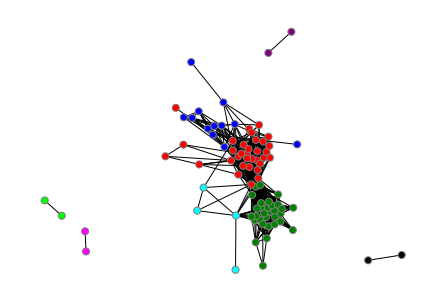

In [ ]:
import os 
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from tcrdist.repertoire import TCRrep
from tcrdist.public import _neighbors_sparse_fixed_radius
from tcrdist.sparse import  add_sparse_pwd

path = ''
f = 'clonotypes_minervina.tsv'
epitopes = ["A02_YLQ"] # Note only this epitope will be considered
edge_threshold = 120

fp = os.path.join(path,f)
df = pd.read_csv(fp, sep = "\t")
df = df[ df.epitope.isin(epitopes)].reset_index(drop = True)
        
df = df.rename(columns = {
    'cdr3b':'cdr3_b_aa', 
    'vb':'v_b_gene', 
    'jb': 'j_b_gene',
    'cdr3a':'cdr3_a_aa', 
    'va': 'v_a_gene', 
    'ja' :'j_a_gene',
    'donor':'subject'} )
df['v_a_gene']  = df['v_a_gene'].apply(lambda x: f"{x}*01")
df['v_b_gene']  = df['v_b_gene'].apply(lambda x: f"{x}*01")
df['j_a_gene']  = df['j_a_gene'].apply(lambda x: f"{x}*01")
df['j_b_gene']  = df['j_b_gene'].apply(lambda x: f"{x}*01")
df['count'] = 1

                        
tr = TCRrep(cell_df = df[['subject','epitope','cdr3_a_aa','v_a_gene','j_a_gene','cdr3_b_aa','v_b_gene','j_b_gene','category','count','cdr3a_nt','cdr3b_nt']] , 
    organism = 'human', 
    chains = ['alpha','beta'],
    deduplicate = True,
    compute_distances = False)

# APPENDIX A: NOTE THE WE CAN COMPUTE ALL PAIRWISE DISTANCES IN SPARSE FORMAT
tr.compute_sparse_rect_distances(df = tr.clone_df, df2=  tr.clone_df, radius = 1000)
# APPENDIX A: NOTE THAT WE MUCH USE THE FUNCTION add_spase_pwd TO COMBINE TWO SPARSE MATRICES
tr.rw_alpha_beta = add_sparse_pwd(tr.rw_beta,tr.rw_alpha)

edge_threshold = 120
network = list()
for i,n in enumerate(_neighbors_sparse_fixed_radius(tr.rw_alpha_beta, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                (tr.rw_alpha_beta)[i,j]      # 'dist'- gets the distance between TCR(i,j)
            ))
            
        
cols = ['node_1', 'node_2', 'dist'] 
df_net = pd.DataFrame(network, columns = cols)
df_net['dist']= df_net['dist'].apply(lambda x: 0 if x == -1 else x) # <- NOTE WE MUST CONVERT BACK FROM -1 to 0
df_net['weight'] = edge_threshold - df_net['dist']
G = nx.from_pandas_edgelist(pd.DataFrame({'source' : df_net['node_1'],'target' : df_net['node_2'], 'weight' :df_net['weight']}))
partition= community_louvain.best_partition(G)
partitions_by_cluster_size = list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {id:rank for id,rank in zip(partitions_by_cluster_size, range(len(partitions_by_cluster_size)))}
partition = {k:partition_reorder.get(v) for k,v in partition.items()}
from tcrdist.html_colors import get_html_colors
clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors   = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": "tab:gray","node_size": 50}
pos = nx.spring_layout(G, seed=2, k = .3) 
nx.draw(G, nodelist = G.nodes, pos = pos, node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes], **options)

## Extra B - Edit Distance 
In Appendix B we illustrate how to compute CDR3 edit-distance networks instead of useing TCRdistances.

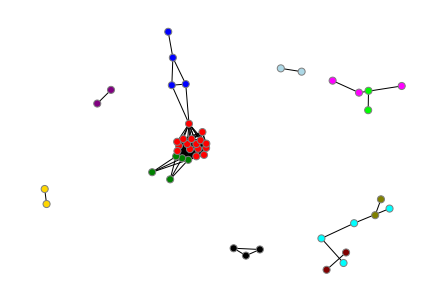

In [ ]:
import os 
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from tcrdist.repertoire import TCRrep
from tcrdist.public import _neighbors_sparse_fixed_radius
from tcrdist.sparse import  add_sparse_pwd
import pwseqdist as pw



path = ''
f = 'clonotypes_minervina.tsv'
epitopes = ["A02_YLQ"] # Note only this epitope will be considered
edge_threshold = 120

fp = os.path.join(path,f)
df = pd.read_csv(fp, sep = "\t")
df = df[ df.epitope.isin(epitopes)].reset_index(drop = True)
        
df = df.rename(columns = {
    'cdr3b':'cdr3_b_aa', 
    'vb':'v_b_gene', 
    'jb': 'j_b_gene',
    'cdr3a':'cdr3_a_aa', 
    'va': 'v_a_gene', 
    'ja' :'j_a_gene',
    'donor':'subject'} )
df['v_a_gene']  = df['v_a_gene'].apply(lambda x: f"{x}*01")
df['v_b_gene']  = df['v_b_gene'].apply(lambda x: f"{x}*01")
df['j_a_gene']  = df['j_a_gene'].apply(lambda x: f"{x}*01")
df['j_b_gene']  = df['j_b_gene'].apply(lambda x: f"{x}*01")
df['count'] = 1

                        
tr = TCRrep(cell_df = df[['subject','epitope','cdr3_a_aa','v_a_gene','j_a_gene','cdr3_b_aa','v_b_gene','j_b_gene','category','count','cdr3a_nt','cdr3b_nt']] , 
    organism = 'human', 
    chains = ['alpha','beta'],
    deduplicate = True,
    compute_distances = False)

# To compute edit distances instead of TCRdists we must configure the correct keyword arguments , weights, metrics, 
kargs_a = {  
    'cdr3_a_aa' : 
        {'use_numba': True},
    'pmhc_a_aa' : {
        'use_numba': True},
    'cdr2_a_aa' : {
        'use_numba': True},
    'cdr1_a_aa' : {
        'use_numba': True}
    }
 
weights_a = { 
    "cdr3_a_aa" : 1,
    "pmhc_a_aa" : 0,
    "cdr2_a_aa" : 0,
    "cdr1_a_aa" : 0}
 
metrics_a = {
     "cdr3_a_aa" : pw.metrics.nb_vector_editdistance,
     "pmhc_a_aa" : pw.metrics.nb_vector_editdistance,
     "cdr2_a_aa" : pw.metrics.nb_vector_editdistance,
     "cdr1_a_aa" : pw.metrics.nb_vector_editdistance }

kargs_b = {  
    'cdr3_b_aa' : 
        {'use_numba': True},
    'pmhc_b_aa' : {
        'use_numba': True},
    'cdr2_b_aa' : {
        'use_numba': True},
    'cdr1_b_aa' : {
        'use_numba': True}
    }
 
weights_b = { 
    "cdr3_b_aa" : 1,
    "pmhc_b_aa" : 0,
    "cdr2_b_aa" : 0,
    "cdr1_b_aa" : 0}
 
metrics_b = {
     "cdr3_b_aa" : pw.metrics.nb_vector_editdistance,
     "pmhc_b_aa" : pw.metrics.nb_vector_editdistance,
     "cdr2_b_aa" : pw.metrics.nb_vector_editdistance,
     "cdr1_b_aa" : pw.metrics.nb_vector_editdistance }


tr.weights_a  = weights_a 
tr.metrics_a  = metrics_a
tr.kargs_a    = kargs_a
tr.weights_b  = weights_b 
tr.metrics_b  = metrics_b 
tr.kargs_b    = kargs_b


tr.compute_sparse_rect_distances(df = tr.clone_df, df2=  tr.clone_df, radius = 10)
tr.rw_alpha_beta = add_sparse_pwd(tr.rw_beta,tr.rw_alpha)

edge_threshold = 1
network = list()
for i,n in enumerate(_neighbors_sparse_fixed_radius(tr.rw_beta, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                tr.rw_beta[i,j],
                tr.rw_alpha[i,j]# 'dist'- gets the distance between TCR(i,j)
            ))
            
        
cols = ['node_1', 'node_2', 'dist','dist_alpha'] 
df_net = pd.DataFrame(network, columns = cols)
df_net['dist']= df_net['dist'].apply(lambda x: 0 if x == -1 else x)  # <- NOTE WE MUST CONVERT BACK FROM -1 to 0
df_net['weight'] = edge_threshold - df_net['dist']
G = nx.from_pandas_edgelist(pd.DataFrame({'source' : df_net['node_1'],'target' : df_net['node_2'], 'weight' :df_net['weight']}))
partition= community_louvain.best_partition(G, random_state=1)
partitions_by_cluster_size = list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {id:rank for id,rank in zip(partitions_by_cluster_size, range(len(partitions_by_cluster_size)))}
partition = {k:partition_reorder.get(v) for k,v in partition.items()}
from tcrdist.html_colors import get_html_colors
clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors   = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": "tab:gray","node_size": 50}
pos = nx.spring_layout(G, seed=2, k = .3) 
nx.draw(G, nodelist = G.nodes, pos = pos, node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes], **options)
plt.savefig("Fig11.pdf")

In [ ]:
plt.show()

## Extra C - Adaptive and AIRR to IMGT Gene Names

Adaptive uses a distinct naming convention to IMGT Nomenclature. This poses a formatting challenge when using ImmunoSEQ files as inputs to tcrdist3. This script provides an example of how to prepaere an Adaptive Immunoseq format file for tcrdist3.

In [ ]:
# Check that file for example 1 available. If not, download it.
import os 
f = 'Adaptive2020.tsv'
url = 'https://raw.githubusercontent.com/kmayerb/tcrdist3/master/Adaptive2020.tsv'
if not os.path.isfile(f):
  os.system(f'wget {url}')

In [ ]:
# Example of converting Adaptive ImmunoSeq file containing 
# a bulk reperoitre into a tcrdist3 ready DataFrame
import pandas as pd
import numpy as np
from tcrdist.repertoire import TCRrep
from tcrdist.swap_gene_name import adaptive_to_imgt

# An example Adaptive ImmunoSeq beta TCRseq input file
filename = 'Adaptive2020.tsv'
chain    = 'beta'  # specify the relevant chain
organism = 'human' # specify the relevant organism 
bulk_df = pd.read_csv(filename, sep = "\t")
# Correct names will depend on TCR chain
item_names = {'alpha' : ["cdr3_b_aa","v_a_gene", "j_a_gene","cdr3_b_nucseq"], 
              'beta'  : ["cdr3_b_aa","v_b_gene","j_b_gene","cdr3_b_nucseq"],
              'gamma' : ["cdr3_g_aa","v_g_gene","j_g_gene","cdr3_g_nucseq"],
              'delta' : ["cdr3_d_aa","v_d_gene","j_d_gene","cdr3_d_nucseq"]}[chain]
# Parse bio-identity
ns= {0:"cdr3_aa", 1:"v_gene", 2:"j_gene"}
# Expand bio_idenitty column to 3-column cdr3,v,j
cdr_v_j = bulk_df['bio_identity'].str.split("+", expand = True).\
    rename(columns = lambda x: ns[x])

bulk_df[[item_names[0], 'v_gene', 'j_gene']] = cdr_v_j
# Convert Names from Adapative to IMGT
bulk_df[item_names[1]] = bulk_df['v_gene'].\
  apply(lambda x : adaptive_to_imgt[organism].get(x))
bulk_df[item_names[2]] = bulk_df['j_gene'].\
  apply(lambda x : adaptive_to_imgt[organism].get(x))

# Validate CDR3
def _valid_cdr3(cdr3):
    """ Return True if all amino acids are part of standard amino acid list"""
    if not isinstance(cdr3, str):
        return False
    else:
        amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
                       'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        valid = np.all([aa in amino_acids for aa in cdr3])
        return valid

bulk_df['valid_cdr3'] = bulk_df[item_names[0]].apply(lambda cdr3: _valid_cdr3(cdr3)) 
bulk_df = bulk_df[bulk_df['valid_cdr3']]

bulk_df['productive_frequency'] = pd.to_numeric(bulk_df['productive_frequency'],errors='coerce')
bulk_df['count'] = pd.to_numeric(bulk_df['templates'],errors='coerce')
bulk_df['subject'] = filename
bulk_df[item_names[3]] = bulk_df['rearrangement']
bulk_df = bulk_df[[ item_names[0],item_names[1],item_names[2], item_names[3],
                   'productive_frequency', 'count','subject']]

# Test that we can initialize a TCRrep distance wiht the bulk_dataframe
tr = TCRrep(cell_df = bulk_df, 
            organism = 'human', 
            chains = ['beta'],
            compute_distances = False)

tr.clone_df.head()

,cdr3_b_aa,v_b_gene,j_b_gene,cdr3_b_nucseq,productive_frequency,subject,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,count,clone_id
0,CAATPGTFISGETYNEQFF,TRBV15*01,TRBJ2-1*01,CTGGGGGACGCAGCCATGTACCTGTGTGCCGCTACTCCCGGGACAT...,0.000084,Adaptive2020.tsv,LNH.......NV,YYD....KDF,P.NTSF,89,1
1,CACLRGETQYF,TRBV30*01,TRBJ2-5*01,ATCCTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATC...,0.000039,Adaptive2020.tsv,GTS......NPN,SVG.....IG,P.QDRQ,41,2
2,CACMGLAGMGDNEQFF,TRBV30*01,TRBJ2-1*01,AAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCTGTGCCTGCATGG...,0.000014,Adaptive2020.tsv,GTS......NPN,SVG.....IG,P.QDRQ,15,3
3,CAGQIRGNIGNGYTF,TRBV2*01,TRBJ1-2*01,CGGTCCACAAAGCTGGAGGACTCAGCCATGTACTTCTGTGCCGGTC...,0.000018,Adaptive2020.tsv,SNH.......LY,FYN....NEI,P.DGSN,19,4
4,CAGRRRVQDEQFF,TRBV6-5*01,TRBJ2-1*01,NNNNNNNTGTCGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTG...,0.000040,Adaptive2020.tsv,MNH.......EY,SVG....AGI,S.TTED,43,5


The Adaptive Immune Receptor Repertoire or AIRR-seq data format is also common. Conversion of the AIRR-seq formatted files to for us in tcrdist3 is also relatively straightforward.

In [ ]:
import os 
f = 'airr2020.tsv'
url = 'https://raw.githubusercontent.com/kmayerb/tcrdist3_book_chapter/main/data/airr2020.tsv'
if not os.path.isfile(f):
  os.system(f'wget {url}')

In [ ]:
import pandas as pd
from tcrdist.swap_gene_name import adaptive_to_imgt
bulk_df = pd.read_csv('airr2020.tsv', sep = "\t")

# specify any columns from the input that are necesseary for the analysis 
additionally_relevant_cols = ['sequence_id']
# specify the relevant chain
chain = 'beta'

item_names = {'alpha':["cdr3_b_aa","v_a_gene", "j_a_gene","cdr3_b_nucseq"], 
              'beta' :["cdr3_b_aa","v_b_gene","j_b_gene","cdr3_b_nucseq"],
              'gamma':["cdr3_g_aa","v_g_gene","j_g_gene","cdr3_g_nucseq"],
              'delta':["cdr3_d_aa","v_d_gene","j_d_gene","cdr3_d_nucseq"]}[chain]

bulk_df = bulk_df.rename(columns = {'junction_aa':item_names[0],
                                    'v_call':item_names[1],
                                    'j_call':item_names[2],
                                    'junction': item_names[3]})

bulk_df[item_names[1]] = bulk_df[item_names[1]].\
  apply(lambda x: x.replace("*00", "*01"))
bulk_df[item_names[2]] = bulk_df[item_names[2]].\
  apply(lambda x: x.replace("*00", "*01"))

# Validate CDR3
def _valid_cdr3(cdr3):
    """ Return True if all amino acids are part of standard amino acid list"""
    if not isinstance(cdr3, str):
        return False
    else:
        amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
                       'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        valid = np.all([aa in amino_acids for aa in cdr3])
        return valid

bulk_df['valid_cdr3'] = bulk_df[item_names[0]].apply(lambda cdr3: _valid_cdr3(cdr3)) 

bulk_df = bulk_df[bulk_df['valid_cdr3']]

# subset to only necessary columns 
item_names = item_names + additionally_relevant_cols
bulk_df = bulk_df[item_names]

# Test that we can initialize a TCRrep distance wiht the bulk_dataframe
tr = TCRrep(cell_df = bulk_df, 
            organism = 'human', 
            chains = ['beta'],
            compute_distances = False)

tr.clone_df.head()

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


,cdr3_b_aa,v_b_gene,j_b_gene,cdr3_b_nucseq,sequence_id,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,count,clone_id
0,CASRPGSSGANVLTF,TRBV6-6*01,TRBJ2-6*01,TGTGCCAGCAGACCCGGAAGCTCTGGGGCCAACGTCCTGACTTTC,609d95a69a878b4751a7b47b,MNH.......NY,SVG....AGI,S.TTED,1,1
1,CASSIDGRSTDTQYF,TRBV19*01,TRBJ2-3*01,TGTGCCAGTAGTATAGACGGCAGAAGCACAGATACGCAGTATTTT,609d95a69a878b4751a7b479,LNH.......DA,SQI....VND,E.KKES,1,2
2,CASSIEGQLSTDTQYF,TRBV19*01,TRBJ2-3*01,TGTGCCAGTAGTATAGAGGGACAGCTTAGCACAGATACGCAGTATTTT,609d95a69a878b4751a7b478,LNH.......DA,SQI....VND,E.KKES,1,3
3,CASSIEGQLSTDTQYF,TRBV19*01,TRBJ2-3*01,TGTGCCAGTAGTATAGAGGGACAGCTTAGCACAGATACGCAGTATTTT,609d95a69a878b4751a7b47a,LNH.......DA,SQI....VND,E.KKES,1,4
4,CASSWYQGGELFF,TRBV12-3*01,TRBJ2-2*01,TGTGCCAGCAGTTGGTATCAGGGTGGGGAGCTGTTTTTT,609d95a69a878b4751a7b476,SGH.......NS,FNN....NVP,P.NASF,1,5


## Extra D - pwseqdist for python power users

The majority of this tutorial has illustrated how to use the tcrdist3 interface. However, it is also useful to recognize that one of its core dependencies **pwseqdist**, written by the same authors, can be used directly. It enables fast and flexible computation of pairwise sequence-based distances using either numba-enabled tcrdist and edit distances or any user-coded Python3 metric to relate TCRs; it can also accommodate computation of “rectangular” pairwise matrices: distances between a relatively small set of TCRs with all TCRs in a much larger set (e.g., bulk repertoire). On a modern laptop, distances can be computed at a rate of ~70M per minute, per CPU.



In [ ]:
import numpy as np
import os
import pandas as pd
import itertools 
import pwseqdist as pw
from scipy.sparse import csr_matrix
# It might be impractical to do brute force comparision of all TCRS, 
# It may be sufficient to compare all CDR3 from TCRS with the same V gene and 
# CDR3 Length. 
file = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv'
df_bulk = pd.read_csv(file, sep = "\t")
df_bulk = df_bulk.sort_values('count', ascending = False).reset_index(drop = True)
df_bulk['rank'] = df_bulk.index.to_list()

### First-Stage: Find pairs with Equal V gene and CDR3 Length

We can reduced the number of total comparison from 1.25 Billion to 1 Million 
by only comparing CDR3 of identical length generated with the same V gene. This may be an attractive option when repertoires contain hundreds of thousands of clones. Recent tools, for instance GIANA by Zhang and Colleages (2021) allows approximate clustering of TCRs with algoritms that are not O(n^2). 

## Second-stage Custering

The pairings from derived from any first-stage algorithms can be input to pwseqdist and the relevant TCRdist or edit distances between CDR3s computed.

In [ ]:
# find all the pairs with equal V gene and CDR3 Length. 
v_gene_index = dict()
df_bulk['length'] = df_bulk['cdr3_b_aa'].apply(lambda x : len(x))
pairs = list()
for i,g in df_bulk.groupby(['v_b_gene','length']):
  combinations = itertools.combinations(g['rank'].to_list(),2)
  v_gene_index[i]= combinations
  pairs.extend(list(combinations))

Note that we can then pass the specific pairings to compare directly to `pw.pairwise.apply_pairwise_sparse`

### Edit Distance on CDR3

In [ ]:
data = pw.pairwise.apply_pairwise_sparse(pw.metrics.nb_vector_editdistance, 
                                         seqs = df_bulk['cdr3_b_aa'] , 
                                         pairs = pairs, ncpus=1, use_numba=True)
# package as a csr_mat
row = [x[0] for x in pairs]
col = [x[1] for x in pairs]
n = df_bulk['rank'].max() + 1
csr_mat_editdistance = csr_matrix((data, (row, col)), shape=(n,n))

### TCRdist on CDR3

In [ ]:
# Compute TCRdistances
data = pw.pairwise.apply_pairwise_sparse(pw.metrics.nb_vector_tcrdist, 
                                         seqs = df_bulk['cdr3_b_aa'], 
                                         pairs = pairs, 
                                         ncpus=1, 
                                         use_numba=True)
data = [-1 if x == 0 else x for x in data]
# package as a csr_mat
row = [x[0] for x in pairs]
col = [x[1] for x in pairs]
n = df_bulk['rank'].max() + 1
csr_mat_tcrdist = csr_matrix((data, (row, col)), shape=(n,n))

### Construct a Network from a Sparse Matrix

In [ ]:
# As before we can quickly find neighbors, and construct a network
from tcrdist.public import _neighbors_sparse_fixed_radius
import networkx as nx
df_bulk['nn'] = _neighbors_sparse_fixed_radius(csr_mat_tcrdist, 12)
df_bulk['k_nn'] = df_bulk['nn'].apply(lambda x: len(x))
network = list()
edge_threshold = 4
for i,n in enumerate(_neighbors_sparse_fixed_radius(csr_mat_tcrdist, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                csr_mat_tcrdist[i,j]               # 'dist'- gets the distance between TCR(i,j)
            ))
cols = ['node_1', 'node_2', 'dist'] 
df_net = pd.DataFrame(network, columns = cols)
df_net['weight'] = edge_threshold - df_net['dist']
G = nx.from_pandas_edgelist(pd.DataFrame({'source' : df_net['node_1'],'target' : df_net['node_2'], 'weight' :df_net['weight']}))

## Extra E - Germline Encoded Distances

In [ ]:
from tcrdist.repertoire import TCRrep
import pandas as pd
 
tr = TCRrep(cell_df = pd.DataFrame(columns = ['cdr3_b_aa','v_b_gene']), 
            chains = ["beta"], organism = "human", compute_distances = False)
all_human_TRBV = [g for g in tr.all_genes['human'].keys() if g.startswith("TRBV")]
tr.cell_df = pd.DataFrame({'v_b_gene' : all_human_TRBV})
tr.cell_df['cdr3_b_aa'] = 'CASSGGSAF'
tr.cell_df['count'] =1
tr.infer_cdrs_from_v_gene(chain = 'beta', imgt_aligned=True)
tr.index_cols = ['cdr3_b_aa', 'cdr2_b_aa','cdr1_b_aa','pmhc_b_aa','v_b_gene']
tr.deduplicate()
tr.compute_distances()
m = tr.pw_cdr1_b_aa + tr.pw_cdr2_b_aa + tr.pw_pmhc_b_aa

/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.7/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [ ]:
from tcrdist.public import _neighbors_fixed_radius
nn_fixed = _neighbors_fixed_radius(m, 24)
network = list() 
edge_threshold = 24
for i,n in enumerate(_neighbors_fixed_radius(m, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,                                 # 'node_1' - row index
                j,                                 # 'node_2' - column index
                m[i,j]               # 'dist'- gets the distance between TCR(i,j)
            ))
cols = ['node_1', 'node_2', 'dist'] 
df_net = pd.DataFrame(network, columns = cols)
df_net['weight'] = edge_threshold - df_net['dist']
G = nx.from_pandas_edgelist(pd.DataFrame({'source' : df_net['node_1'],'target' : df_net['node_2'], 'weight' :df_net['weight']}))

In [ ]:
import community.community_louvain as community_louvain
partition= community_louvain.best_partition(G)

In [ ]:
x = {tr.clone_df['v_b_gene'].iloc[int(k)]:v for k,v in partition.items()}
d = dict()
for k,v in x.items():
  d.setdefault(v, []).append(k)

In [ ]:
d

{0: ['TRBV29-1*01',
  'TRBV29-1*02',
  'TRBV29-1*03',
  'TRBV29/OR9-2*01',
  'TRBV29/OR9-2*02'],
 1: ['TRBV12-1*01',
  'TRBV12-2*01',
  'TRBV7-6*01',
  'TRBV7-6*02',
  'TRBV7-7*01',
  'TRBV7-7*02',
  'TRBV7-9*07',
  'TRBV7-8*01',
  'TRBV7-8*02',
  'TRBV7-8*03',
  'TRBV7-4*01',
  'TRBV7-9*01',
  'TRBV7-9*02',
  'TRBV7-9*03',
  'TRBV7-9*04',
  'TRBV7-9*05',
  'TRBV7-9*06'],
 2: ['TRBV12-4*01', 'TRBV12-4*02', 'TRBV12-3*01'],
 3: ['TRBV15*01', 'TRBV15*02', 'TRBV15*03'],
 4: ['TRBV11-1*01',
  'TRBV11-2*01',
  'TRBV11-2*02',
  'TRBV11-2*03',
  'TRBV11-3*01',
  'TRBV11-3*02',
  'TRBV11-3*03'],
 5: ['TRBV7-1*01',
  'TRBV7-2*02',
  'TRBV7-2*03',
  'TRBV7-2*01',
  'TRBV7-2*04',
  'TRBV7-3*01',
  'TRBV7-3*02',
  'TRBV7-3*03',
  'TRBV7-3*04',
  'TRBV7-3*05'],
 6: ['TRBV21/OR9-2*01',
  'TRBV21-1*01',
  'TRBV16*02',
  'TRBV16*01',
  'TRBV16*03',
  'TRBV23-1*01',
  'TRBV23/OR9-2*02',
  'TRBV23/OR9-2*01'],
 7: ['TRBV14*01', 'TRBV14*02'],
 8: ['TRBV13*01', 'TRBV13*02'],
 9: ['TRBV2*01', 'TRBV2*02', 'TR

m

# References

Mayer-Blackwell, K., Schattgen, S., Cohen-Lavi, L., Crawford, J. C., Souquette, A., Gaevert, J. A., ... & Fiore-Gartland, A. (2021). TCR meta-clonotypes for biomarker discovery with tcrdist3 enabled identification of public, HLA-restricted clusters of SARS-CoV-2 TCRs. Elife, 10, e68605.

Britanova OV, Shugay M, Merzlyak EM, Staroverov DB, Putintseva EV, Turchaninova MA, Mamedov IZ, Pogorelyy MV, Bolotin DA, Izraelson M, Davydov AN, Egorov ES, Kasatskaya SA, Rebrikov DV, Lukyanov S, Chudakov DM. 2016. Dynamics of individual T Cell repertoires: from cord blood to centenarians. The Journal of Immunology 196:5005–5013.

Dash P, Fiore-Gartland AJ, Hertz T, Wang GC, Sharma S, Souquette A, Crawford JC, Clemens EB, Nguyen THO, Kedzierska K, La Gruta NL, Bradley P, Thomas PG. 2017. Quantifiable predictive features define epitope-specific T cell receptor repertoires. Nature 547:89–93.

Marcou Q, Mora T, Walczak AM. 2018. High-throughput immune repertoire analysis with IGoR. Nat Commun 9:561.


Minervina AA, Pogorelyy MV, Kirk AM, Allen EK, Allison KJ, Lin C-Y, Brice DC, Zhu X, Vegesana K, Wu G, Crawford JC, Schultz-Cherry S, Estepp JH, McGargill MA, SJTRC Study Team, Wolf J, Thomas PG. 2021. Convergent epitope-specific T cell responses after SARS-CoV-2 infection and vaccination. medRxiv. doi:10.1101/2021.07.12.21260227

Ren X, Wen W, Fan X, Hou W, Su B, Cai P, Li J, Liu Y, Tang F, Zhang F, Yang Y, He J, Ma W, He J, Wang P, Cao Q, Chen F, Chen Y, Cheng X, Deng G, Deng X, Ding W, Feng Y, Gan R, Guo C, Guo W, He S, Jiang C, Liang J, Li Y-M, Lin J, Ling Y, Liu H, Liu J, Liu N, Liu S-Q, Luo M, Ma Q, Song Q, Sun W, Wang G, Wang F, Wang Y, Wen X, Wu Q, Xu G, Xie X, Xiong X, Xing X, Xu H, Yin C, Yu D, Yu K, Yuan J, Zhang B, Zhang P, Zhang T, Zhao J, Zhao P, Zhou J, Zhou W, Zhong S, Zhong X, Zhang S, Zhu L, Zhu P, Zou B, Zou J, Zuo Z, Bai F, Huang X, Zhou P, Jiang Q, Huang Z, Bei J-X, Wei L, Bian X-W, Liu X, Cheng T, Li X, Zhao P, Wang F-S, Wang H, Su B, Zhang Z, Qu K, Wang X, Chen J, Jin R, Zhang Z. 2021. COVID-19 immune features revealed by a large-scale single-cell transcriptome atlas. Cell 184:1895–1913.e19.

Sethna Z, Elhanati Y, Callan CG, Walczak AM, Mora T. 2019. OLGA: fast computation of generation probabilities of B- and T-cell receptor amino acid sequences and motifs. Bioinformatics 35:2974–2981.

